In [1]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points, plotting_positions, Weibull_probability_plot
from reliability.Utils import axes_transforms, probability_plot_xylims, probability_plot_xyticks, linear_regression
from reliability.Distributions import Weibull_Distribution

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler
from matplotlib import colors, colormaps
import matplotlib.ticker as mticker
import pandas as pd
from matplotlib.figure import figaspect
import seaborn as sns
import numpy as np
from scipy.special import gamma
from scipy.stats import weibull_min, linregress
from scipy.optimize import minimize
import itertools
import math
from shapely import Polygon
from shapely.plotting import plot_polygon
from collections import namedtuple
from sklearn.metrics import r2_score

# Configuration

In [2]:
angle_method = "Angle" ## Calculate strength via fracture angle or simple diameter
design_prob = 1-0.05 ## Desired quantile of survival for design

standard_dia = 1

standard_v = (standard_dia/2)**2 * np.pi * 180
standard_sa = standard_dia * np.pi * 180

In [3]:
stress_label = "Failure stress (MPa)"
v_label = "Volume ($mm^3$)"
sa_label = "Surface area ($mm^2$)"

In [4]:
plt.style.use('seaborn-v0_8-ticks')
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["scatter.marker"] = "."

In [5]:
marker_cycler = itertools.cycle(("^", "o", "x", "+"))

# Example

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRX)
Failures / Right censored: 20/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         28.1297          3.6749   21.7752   36.3385
     Beta         1.80611        0.316663   1.28087   2.54674 

Goodness of fit    Value
 Log-likelihood  -79.565
           AICc  163.836
            BIC  165.121
             AD 0.817695 



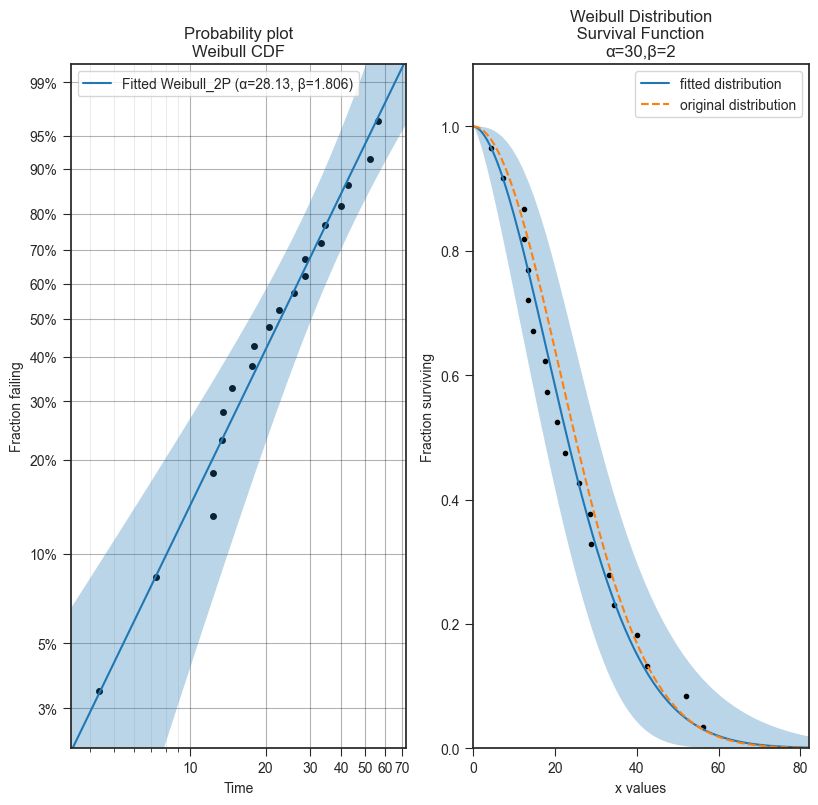

In [6]:
example_dist = Weibull_Distribution(alpha=30, beta=2)  # creates the distribution object
example_data = example_dist.random_samples(20, seed=42)  # draws 20 samples from the distribution. Seeded for repeatability
plt.subplot(121)
fit = Fit_Weibull_2P(failures=example_data, method="LS")  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
example_dist.SF(label='original distribution', linestyle='--') # plots the survival function of the original distribution
plot_points(failures=example_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

In [7]:
example_data

array([20.55094355, 52.04910458, 34.42486201, 28.66440822, 12.355662  ,
       12.35462111,  7.33858922, 42.54536142, 28.76063174, 33.28851237,
        4.32658956, 56.15337681, 40.09721423, 14.65670027, 13.43916254,
       13.50371358, 18.06871209, 25.87537532, 22.56065957, 17.60115602])

# 3.5mm Sample Test

In [8]:
test_data = pd.read_csv("Test_data.csv")

test_data

,Unnamed: 0,Proben-Nr.,Datum/Uhrzeit,Fcr,...,Moment,failure stress,Unnamed: 10,Diameter.1
0,NaN,NaN,NaN,N,...,Nmm,N/mm^2,NaN,mm
1,Probe 1,1,45420.6,22.85162354,...,342.8,76.7,NaN,3.57
2,Probe 2,2,45420.7,22.49817848,...,337.5,74.9,NaN,3.58
3,Probe 3,3,45420.7,18.44078827,...,276.6,62.4,NaN,3.56
4,Probe 4,4,45420.7,22.20804024,...,333.1,79.8,NaN,3.49
5,Probe 5,5,45420.7,23.90054512,...,358.5,83.7,NaN,3.52
6,Probe 6,6,45420.7,25.65187645,...,384.8,87.6,NaN,3.55
7,Probe 7,7,45420.7,26.03781509,...,390.6,87.4,NaN,3.57
8,Probe 8,8,45420.7,26.57203484,...,398.6,93.1,NaN,3.52
9,Probe 9,9,45420.7,18.93573761,...,284.0,65.8,NaN,3.53


In [9]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(test_data):
    # Drop columns: 'Unnamed: 0', 'Unnamed: 10'
    test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 10'])
    # Drop rows with missing data in column: 'Proben-Nr.'
    test_data = test_data.dropna(subset=['Proben-Nr.'])
    # Change column type to uint32 for column: 'Proben-Nr.'
    test_data = test_data.astype({'Proben-Nr.': 'uint32'})
    # Rename column 'Proben-Nr.' to 'Probe_Num'
    test_data = test_data.rename(columns={'Proben-Nr.': 'Probe_Num'})
    return test_data

test_data_clean = clean_data(test_data.copy())
test_data_clean.head()

,Probe_Num,Datum/Uhrzeit,Fcr,Diameter,...,span,Moment,failure stress,Diameter.1
1,1,45420.6,22.85162354,3.57,...,30.0,342.8,76.7,3.57
2,2,45420.7,22.49817848,3.58,...,30.0,337.5,74.9,3.58
3,3,45420.7,18.44078827,3.56,...,30.0,276.6,62.4,3.56
4,4,45420.7,22.20804024,3.49,...,30.0,333.1,79.8,3.49
5,5,45420.7,23.90054512,3.52,...,30.0,358.5,83.7,3.52


In [10]:
test_fail_data = test_data_clean['failure stress'].to_numpy(dtype="float32")
test_fail_data

array([ 76.7,  74.9,  62.4,  79.8,  83.7,  87.6,  87.4,  93.1,  65.8,
        71.2,  71.6,  89.5, 101.6, 105. ,  74.3,  78. ,  92. ,  94.6,
        81.5,  73.4,  79. ,  89.7,  83.6,  86.5, 115.6,  81.6,  60.4,
        87.8,  86.3, 102. ,  72.4,  85.9], dtype=float32)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRY)
Failures / Right censored: 32/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         88.6653         2.15064   84.5487   92.9823
     Beta         7.99328        0.968069   6.30428   10.1348 

Goodness of fit    Value
 Log-likelihood -127.807
           AICc  260.028
            BIC  262.546
             AD  1.07659 



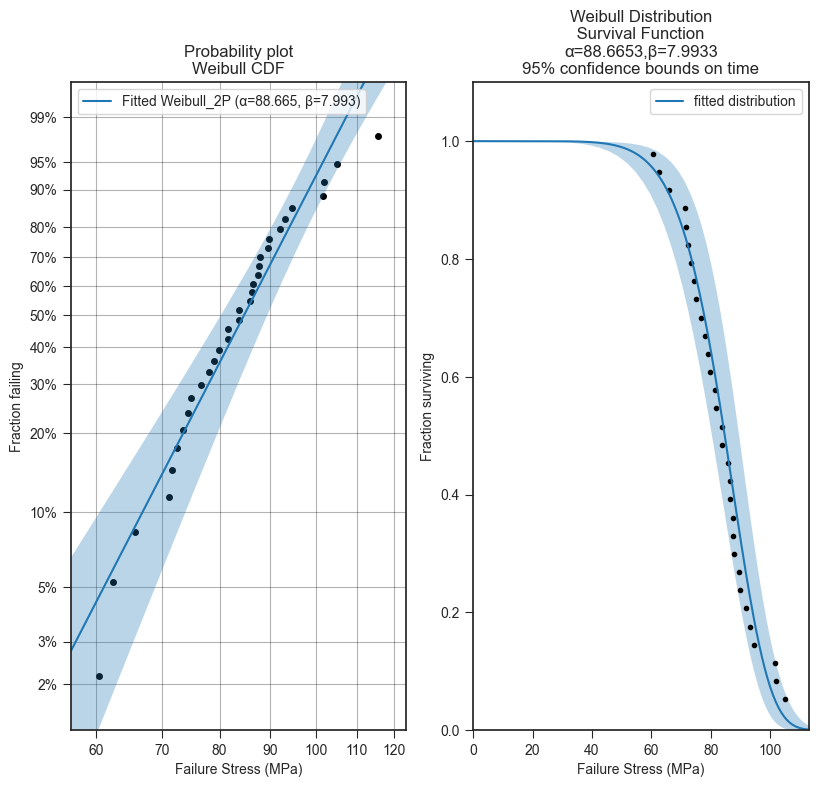

In [11]:
plt.clf()
plt.subplot(121)
test_fit = Fit_Weibull_2P(failures=test_fail_data, method="LS")  # fits a Weibull distribution to the data and generates the probability plot
plt.xlabel("Failure Stress (MPa)")
plt.subplot(122)
test_fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=test_fail_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.xlabel("Failure Stress (MPa)")
plt.show()

In [12]:
test_fail_data

array([ 76.7,  74.9,  62.4,  79.8,  83.7,  87.6,  87.4,  93.1,  65.8,
        71.2,  71.6,  89.5, 101.6, 105. ,  74.3,  78. ,  92. ,  94.6,
        81.5,  73.4,  79. ,  89.7,  83.6,  86.5, 115.6,  81.6,  60.4,
        87.8,  86.3, 102. ,  72.4,  85.9], dtype=float32)

In [13]:
val_test = -8

test_fail_data[val_test]

np.float32(115.6)

In [14]:
cdf_test = test_fit.distribution.CDF(xvals=[test_fail_data[val_test]], show_plot=False) ## Calculates values along the line

print(test_fail_data[val_test], " ", cdf_test)

115.6   0.9997598194127818


In [15]:
test_points = plotting_positions(test_fail_data) ## Calculates where the points on the scatter should go

print(test_points[0][val_test], " ", test_points[1][val_test])

115.5999984741211   0.9783950617283951


Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRX)
Failures / Right censored: 4/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         81.0777         5.01467   71.8215   91.5268
     Beta         8.69721         3.65749   3.81433   19.8308 

Goodness of fit    Value
 Log-likelihood -14.1335
           AICc  44.2669
            BIC  31.0395
             AD  2.84994 



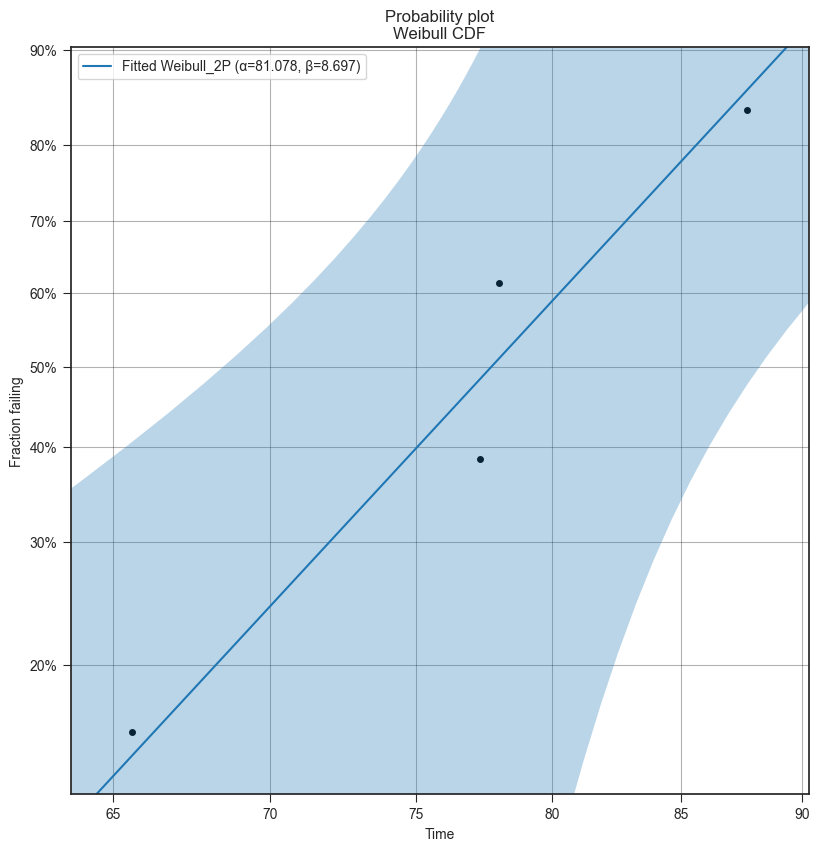

In [16]:
test_data_e = np.array([78, 65.6 , 87.7 , 77.3])
test_fit = Fit_Weibull_2P(failures=test_data_e, method="LS")

In [17]:
test_fit.results

,Parameter,Point Estimate,Standard Error,Lower CI,Upper CI
0,Alpha,81.0777,5.01467,71.8215,91.5268
1,Beta,8.69721,3.65749,3.81433,19.8308


# Load in and clean data

In [18]:
gcc_data = pd.read_csv("Maple Rod Testing Analysis.csv")

In [19]:
stiff_data = pd.read_csv("Stiffness\\Rod_stiffness_20250317-1030.csv")

In [20]:
gcc_data = pd.merge(gcc_data, stiff_data, on="sample")

In [21]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(gcc_data):
    # Drop rows with missing data in column: 'fracture_stress'
    gcc_data = gcc_data.dropna(subset=['fracture_stress'])
    gcc_data = gcc_data.dropna(how="all", axis=1)
    return gcc_data

gcc_data_clean = clean_data(gcc_data.copy())

In [22]:
gcc_data_clean["series"] = gcc_data_clean["sample"].str[0] ## Extract series letter from the "sample" column

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["sample"] == "D5"].index) ## Drop this outlier for now, remember to determine if this needs further inspection

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["series"] == "X"].index) ## Drop the x series, these were just to test setup

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["series"] == "L"].index) ## Drop the L series, we dont want it

gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["series"] == "J"].index) ## Drop the J series, its an outlier, determine if this needs further inspection

In [23]:
gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,stiff_rsquared,stiff_stderr,stiff_intercept_stderr,series
0,B1,46.7887,67.761,5.23,...,0.998693,0.017214,0.0434286,B
1,B2,85.8979,170.977,5.28,...,0.999184,0.0146036,0.0692124,B
2,B3,54.1228,102.886,5.3,...,0.999056,0.0178639,0.0592741,B
3,B4,64.6418,122.189,5.31,...,0.999203,0.0155251,0.0547607,B
4,B5,78.9588,174.763,5.09,...,0.999414,0.0179146,0.0794565,B
5,B6,57.2761,116.623,5.18,...,0.999184,0.0276003,0.0993303,B
6,B7,68.1001,128.726,5.31,...,0.999632,0.0168685,0.0582159,B
7,B8,80.9788,162.4,5.24,...,0.999428,0.0201934,0.082028,B
8,B9,56.073,108.539,5.22,...,0.999525,0.020953,0.0657883,B
9,B10,92.3955,179.794,5.32,...,0.999798,0.0119736,0.0576809,B


# Analyse Strength

## Functions

In [24]:
def simple_fracture_stress(load, support_span, load_span, diameter):
    ### Calculate fracture stress without accounting for fracture angle
    pin_distance = (support_span - load_span) / 2
    return (16 * load * pin_distance) / (np.pi * diameter**3)

In [25]:
def calc_fracture_stress(sample_data):
    ### Batch calculate simple fracture stress
    sample_data["old_fracture_stress"] = sample_data["fracture_stress"]
    sample_data["fracture_stress"] = sample_data.apply(lambda row: simple_fracture_stress(row["fracture_load"], row["support_span"], row["load_span"], row["fracture_diameter"]), axis=1)
    return sample_data

In [26]:
def fit_and_plot_weibull(data, design_failure):
    ### Big function to fit and plot the needed weibull distributions of each series. Saves a figure of individual and collated distributions

    ## Set up matplotlib figures and axes
    ind_fig, ind_ax = plt.subplots()
    collated_fig, collated_ax = plt.subplots()
    
    ## Create a separate dataframe with statistics considering the entire series
    data_anal = data[["series", "fracture_diameter", "fracture_stress"]].groupby("series").agg(['mean', "std"])
    data_anal.columns = data_anal.columns.map('_'.join)
    data_anal["fracture_stress_CV"] = data_anal["fracture_stress_std"] / data_anal["fracture_stress_mean"] * 100

    ## Sort the values to display nicer in figure legends
    data_anal = data_anal.sort_values("fracture_diameter_mean")

    fracture_prob = pd.DataFrame()

    unique_values = data_anal.index.unique()

    ## Fit a weibull distribution to each series, also keeping the plotting positions to be scaled later
    for letter in unique_values:
        method = data.loc[data["series"] == letter, "method"].iloc[0]
        fracture_frame = data.loc[data["series"] == letter, ["fracture_stress"]].copy()
        plot_data = fracture_frame.squeeze(axis=1).to_numpy(dtype="float32")

        data_anal.loc[letter, "support_span"] = data.loc[data["series"] == letter, "support_span"].iloc[0]
        data_anal.loc[letter, "load_span"] = data.loc[data["series"] == letter, "load_span"].iloc[0]

        ## Skip fitting if sample size is too small
        if len(plot_data) < 2: continue
        
        avg_diameter = data_anal.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm dia." % (letter, avg_diameter)
        
        plt.sca(ind_ax)
        ## Fit the current data to a weibull (Also makes a figure)
        fracture_fit = Fit_Weibull_2P(failures=plot_data, print_results=False, label=legend_text, method="LS", CI_type="none")
        
        ## Individual figure formatting
        ind_ax.get_lines()[0].set_color("red")
        ind_ax.get_lines()[0].set_linestyle("dashed")
        ind_fig.set_size_inches(7, 8)
        plt.ylabel("Probability of failure")
        plt.xlabel(stress_label)
        plt.title("")
        plt.legend(loc="upper left")

        ## Save and clear fig
        ind_fig.savefig("Figs/series_" + letter, bbox_inches = "tight")
        ind_ax.cla()

        ## Also grab the plotting positions from the reliability library
        fail_x, fail_y = plotting_positions(plot_data, a=0.5)
        fracture_frame.loc[:, "Fail Check"] = fail_x ## This should be the same as "fracture_stress"
        fracture_frame.loc[:, "Fail Prob"] = fail_y

        fracture_frame["char_strength"] = fracture_fit.alpha
        fracture_frame["weibull_modulus"] = fracture_fit.beta

        fracture_frame = fracture_frame.drop(["fracture_stress"], axis=1)
        fracture_prob =  pd.concat([fracture_prob, fracture_frame], axis=0)

        data_anal.loc[letter, "valid_samples"] = len(plot_data)
        data_anal.loc[letter, "char_strength"] = fracture_fit.alpha
        data_anal.loc[letter, "char_strength_95%_upper"] = fracture_fit.alpha_upper
        data_anal.loc[letter, "char_strength_95%_lower"] = fracture_fit.alpha_lower
        data_anal.loc[letter, "weibull_modulus"] = fracture_fit.beta
        data_anal.loc[letter, "weibull_modulus_95%_upper"] = fracture_fit.beta_upper
        data_anal.loc[letter, "weibull_modulus_95%_lower"] = fracture_fit.beta_lower
        data_anal.loc[letter, "Design Strength"] = fracture_fit.distribution.inverse_SF(design_failure)
        data_anal.loc[letter, "method"] = method

        collated_legend_text = "%s, dia.= ~%.2f mm" % (letter, avg_diameter)

        ## Add a line to the collated figure
        plt.sca(collated_ax)

        if method == "vitri":
            comb_linestyle = "-"
        else:
            comb_linestyle = "--"
            
        Weibull_probability_plot(failures=plot_data, __fitted_dist_params=fracture_fit.distribution, show_scatter_points=False, CI_type=None, label=collated_legend_text, linestyle=comb_linestyle)

    ind_fig.clf()

    ## Collated figure formatting and save
    collated_ax.set_title("")
    collated_ax.set_ylabel("Probability of failure")
    collated_ax.set_xlabel(stress_label)

    collated_fig.set_size_inches(7, 8)

    collated_ax.set_xlim([10, 300])
    collated_ax.set_ylim([0.1, 0.9])

    collated_fig.savefig("Figs/collated", bbox_inches = "tight")

    ## Save relevant data back to the original dataframe
    data = pd.concat([data, fracture_prob], axis=1)

    return data, data_anal

## Run Analysis

In [27]:
## GCC uses fracture angle to alter the maximum stress experienced. Set angle_method = "Normal" to change this to simple stress calc

if angle_method == "Normal":
    gcc_data_clean = calc_fracture_stress(gcc_data_clean)
    gcc_data_clean
elif angle_method == "Angle":
    pass
else:
    raise ValueError("Please choose method 'Normal' or 'Angle'")

<Figure size 700x800 with 0 Axes>

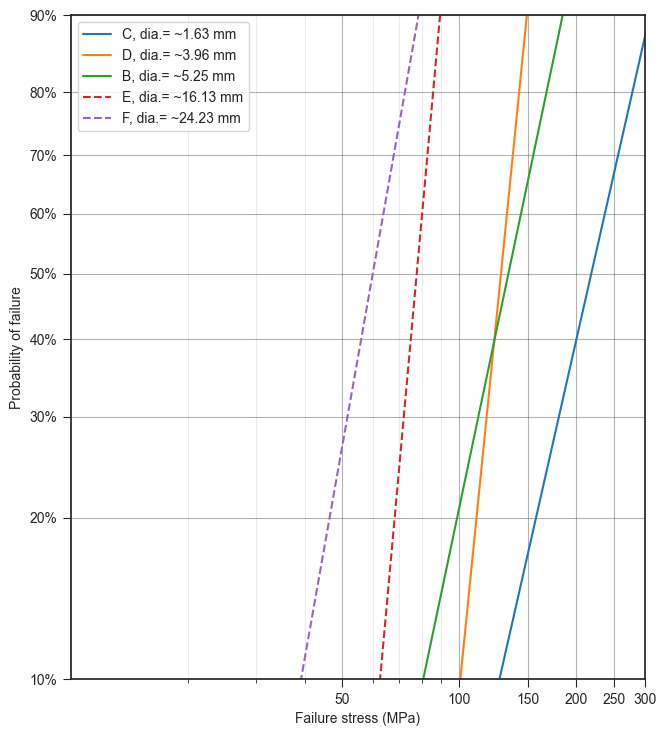

In [28]:
gcc_data_clean, gcc_data_anal = fit_and_plot_weibull(gcc_data_clean, design_prob)

In [29]:
## Double check if appended plotting positions align with original fracture stress

check_alignment = gcc_data_clean[["fracture_stress", "Fail Check"]].dropna()

check_alignment = np.isclose(check_alignment["fracture_stress"], check_alignment["Fail Check"])
check_alignment

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [30]:
gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Check,Fail Prob,char_strength,weibull_modulus
0,B1,46.7887,67.761,5.23,...,67.761,0.05,147.631,3.73272
1,B2,85.8979,170.977,5.28,...,170.977,0.75,147.631,3.73272
2,B3,54.1228,102.886,5.3,...,102.886,0.15,147.631,3.73272
3,B4,64.6418,122.189,5.31,...,122.189,0.45,147.631,3.73272
4,B5,78.9588,174.763,5.09,...,174.763,0.85,147.631,3.73272
5,B6,57.2761,116.623,5.18,...,116.623,0.35,147.631,3.73272
6,B7,68.1001,128.726,5.31,...,128.726,0.55,147.631,3.73272
7,B8,80.9788,162.4,5.24,...,162.4,0.65,147.631,3.73272
8,B9,56.073,108.539,5.22,...,108.539,0.25,147.631,3.73272
9,B10,92.3955,179.794,5.32,...,179.794,0.95,147.631,3.73272


# Size effect normalisation

## Functions

In [31]:
## Simple sample surface area and volume
def cylinder_gage_SA(diameter: float, length: float) -> float: return np.pi * diameter * length
def cylinder_gage_V(diameter: float, length: float) -> float: return (np.pi * diameter**2 * length) / 4

In [32]:
## A combined gamma function required for the effective surface area of a cylinder (See ASTM-1683)
def combined_gamma(modulus):
    return (gamma((modulus + 1) / 2) * gamma(3/2)) / (gamma((modulus + 4) / 2))

## Formulae to calc effective surface area and volume of cylinders in bending (See ASTM-1683)
def effective_SA(gage_SA, load_span, support_span, modulus):
    comb_gamma = combined_gamma(modulus)
    return ((load_span / support_span) * modulus + 1) * ((modulus + 2) / 2) * (1/(modulus + 1)) * (comb_gamma / np.pi) * gage_SA

def effective_V(gage_V, load_span, support_span, modulus):
    comb_gamma = combined_gamma(modulus)
    return ((load_span / support_span) * modulus + 1) * (1/(modulus + 1)) * (comb_gamma / np.pi) * gage_V

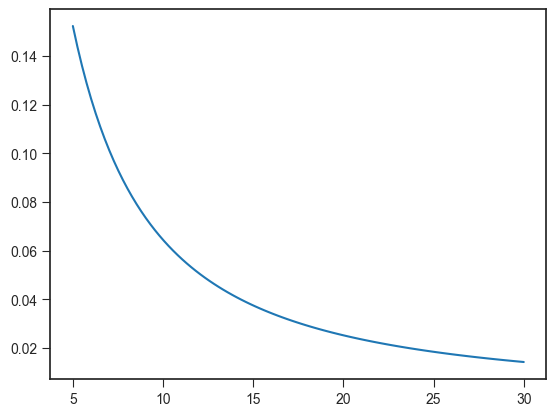

In [33]:
gamma_test = np.linspace(5,30,100)
plt.plot(gamma_test, combined_gamma(gamma_test))

In [34]:
effective_V(200, 60, 180, 5)

np.float64(4.311498987462984)

In [35]:
effective_SA(1979, 60, 180, 3)

np.float64(209.9784215859072)

In [36]:
def calc_sample_geometry(sample_data: pd.DataFrame, analysis_data: pd.DataFrame):
    ### Calculate the required geometry for each value in the dataframe

    ## Simple V and SA for individual samples
    sample_data["gage_V"] = sample_data.apply(lambda row: cylinder_gage_V(row["fracture_diameter"], row["support_span"]), axis=1)
    sample_data["gage_SA"] = sample_data.apply(lambda row: cylinder_gage_SA(row["fracture_diameter"], row["support_span"]), axis=1)

    calc_V_helper = lambda row: effective_V(row["gage_V"], row["load_span"],  row["support_span"], row["weibull_modulus"])
    calc_SA_helper = lambda row: effective_SA(row["gage_SA"], row["load_span"],  row["support_span"], row["weibull_modulus"])

    ## Effective V and SA for individual samples
    sample_data["effective_V"] = sample_data.apply(calc_V_helper, axis=1)
    sample_data["effective_SA"] = sample_data.apply(calc_SA_helper, axis=1)

    ## Simple V and SA for series
    analysis_data["mean_gage_V"] = analysis_data.apply(lambda row: cylinder_gage_V(row["fracture_diameter_mean"], row["support_span"]), axis=1)
    analysis_data["mean_gage_SA"] = analysis_data.apply(lambda row: cylinder_gage_SA(row["fracture_diameter_mean"], row["support_span"]), axis=1)

    calc_V_helper = lambda row: effective_V(row["mean_gage_V"], row["load_span"],  row["support_span"], row["weibull_modulus"])
    calc_SA_helper = lambda row: effective_SA(row["mean_gage_SA"], row["load_span"],  row["support_span"], row["weibull_modulus"])

    ## Effective V and SA for series
    analysis_data["mean_effective_V"] = analysis_data.apply(calc_V_helper, axis=1)
    analysis_data["mean_effective_SA"] = analysis_data.apply(calc_SA_helper, axis=1)

    return sample_data, analysis_data

In [37]:
def scale_strength(strength, effective_size, modulus):
    return strength * (effective_size ** (1/modulus))

In [38]:
scale_strength(np.array([5,5,5]), np.array([20,20,20]),np.array([5,5,5]))

array([9.10282102, 9.10282102, 9.10282102])

In [39]:
def size_effect_normalize(original_prob: float, original_size: float, standard_size: float) -> float:
    ### Normalising formula from sphere compression paper (among other places)
    size_ratio = standard_size / original_size
    return 1 - (1 - original_prob)**size_ratio

In [40]:
def normalize_data(data, v_standard, sa_standard):
    ### Probability normalised to a standard size

    data["Fail Prob V Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["effective_V"], v_standard), axis=1)
    data["Fail Prob SA Adj"] = data.apply(lambda row: size_effect_normalize(row["Fail Prob"], row["effective_SA"], sa_standard), axis=1)

    data["standard_gage_v"] = v_standard
    data["standard_gage_sa"] = sa_standard

    return data

In [41]:
## Depreciated function used for another method of size scaling

# def size_shift_data(sample_data, analysis_data):
#     sample_data["SA_scale_param"] = sample_data.apply(lambda row: scale_strength(row["fracture_stress"], row["effective_SA"], row["weibull_modulus"]), axis=1)
#     sample_data["V_scale_param"] = sample_data.apply(lambda row: scale_strength(row["fracture_stress"], row["effective_V"], row["weibull_modulus"]), axis=1)
    
#     analysis_data["SA_series_scale_param"] = analysis_data.apply(lambda row: scale_strength(row["char_strength"], row["mean_effective_SA"], row["weibull_modulus"]), axis=1)
#     analysis_data["V_series_scale_param"] = analysis_data.apply(lambda row: scale_strength(row["char_strength"], row["mean_effective_V"], row["weibull_modulus"]), axis=1)

#     return sample_data, analysis_data

In [42]:
def fit_normalized_data(data, method):
    ### Use least squares regression to fit a line to the normalised values. Also do the transformations required for weibull parameters
    if method == "V":
        method_column = "Fail Prob V Adj"
    elif method == "SA":
        method_column = "Fail Prob SA Adj"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")
    
    least_squares_data = data[["fracture_stress", method_column]].dropna()

    stress = least_squares_data["fracture_stress"].to_numpy()
    fail_prob = least_squares_data[method_column].to_numpy()

    x = np.log(stress)
    y = np.log(-np.log(1-fail_prob))

    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRX",show_plot=True,label='RRX')
    # m, c = linear_regression(x=x,y=y,RRX_or_RRY="RRY",show_plot=True,label='RRY')

    result = linregress(x, y)

    beta = result.slope
    alpha = np.exp(-result.intercept / beta)

    return (alpha, beta, result.rvalue)
    

In [43]:
## Depreciated function used for another method of size scaling

# def fit_normalized_data(data, method):
#     if method == "V":
#         method_column = "V_scale_param"
#     elif method == "SA":
#         method_column = "SA_scale_param"
#     else:
#         raise("Please choose a valid method, volume (V) or surface area (SA)")
    
#     least_squares_data = data[[method_column, "Fail Prob"]].dropna()

#     stress = least_squares_data[method_column].to_numpy()
#     fail_prob = least_squares_data["Fail Prob"].to_numpy()

#     x = np.log(stress)
#     y = np.log(-np.log(1-fail_prob))

#     m, c = np.polyfit(x, y, 1)

#     beta = m
#     alpha = np.exp(-c / beta)

#     return (alpha, beta)

In [44]:
def plot_normalized_weibull(data, analysed_data):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    spacing = 0.05

    ## Work out limits for scaling
    x_max = np.log10(data["fracture_stress"].max())
    x_min = np.log10(data["fracture_stress"].min())

    x_range = x_max - x_min
    
    xlims = [10 **(x_min - x_range * spacing),
             10 **(x_max + x_range * spacing)]
    
    ## For volume
    y_max = axes_transforms.weibull_forward(data["Fail Prob V Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob V Adj"].min())

    y_range = y_max - y_min
    
    v_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
               axes_transforms.weibull_inverse(y_max + y_range * spacing)]
    
    y_max = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].min())

    y_range = y_max - y_min
    
    sa_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
                axes_transforms.weibull_inverse(y_max + y_range * spacing)]

    ##  Get parameters required to generate weibull distributions
    v_alpha, v_beta, v_r = fit_normalized_data(data, "V")
    sa_alpha, sa_beta, sa_r = fit_normalized_data(data, "SA")

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_alpha, beta=v_beta)
    sa_dist = Weibull_Distribution(alpha=sa_alpha, beta=sa_beta)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(xlims[0], xlims[1], 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(xlims[0], xlims[1], 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$, $r^2 = {:.2f}$"

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_alpha, v_beta, v_r**2))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_alpha, sa_beta, sa_r**2))

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="fracture_stress", y="Fail Prob V Adj", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="fracture_stress", y="Fail Prob SA Adj", label=legend_text, marker=marker_symb)

    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    ax_v.set_xlim(xlims)
    ax_v.set_ylim(v_ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    plt.sca(ax_sa)
    ax_sa.set_xlim(xlims)
    ax_sa.set_ylim(sa_ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(12, 9)

    print("Volume rsquared = ", v_r**2)
    print("Standard volume = ", data["standard_gage_v"].iloc[0], '\n')

    print("Surface area rsquared = ", sa_r**2)
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])

    return v_dist, sa_dist

In [45]:
# def plot_normalized_weibull(data, analysed_data, alpha, beta, method):
#     if method == "V":
#         method_column = "V_scale_param"
#         method_title = "volume"
#     elif method == "SA":
#         method_column = "SA_scale_param"
#         method_title = "surface_area"
#     else:
#         raise("Please choose a valid method, volume (V) or surface area (SA)")

#     normalise_unique_series = data.dropna()["series"].unique()
    
#     normal_dist_x = np.linspace(100,1000000, 200)
#     normalised_dist_y = Weibull_Distribution(alpha=alpha, beta=beta).CDF(xvals=normal_dist_x, show_plot=False)

#     fig, ax = plt.subplots(layout="constrained")
#     ax.plot(normal_dist_x, normalised_dist_y, label="Best Fit")

#     color = iter(plt.cm.Dark2(np.linspace(0, 1, len(normalise_unique_series))))
#     title_text = method_title + " Normalised Weibull Probability\nScale= %.2f MPa  Shape= %.2f" % (alpha, beta)

#     for i, letter in enumerate(normalise_unique_series):
#         plot_data = data.loc[data["series"] == letter]


#         c = next(color)

#         avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
#         legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)
#         ax.scatter(data=plot_data, x=method_column, y="Fail Prob", marker="^", color=c, label=legend_text)

#     ax.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
#     ax.set_xscale("log")

#     probability_plot_xyticks()
#     probability_plot_xylims(normal_dist_x, normalised_dist_y, "weibull")

#     ax.set_xlabel("Failure Stress (MPa)")
#     ax.set_ylabel("Probability of failure")
#     ax.set_title(title_text)

#     ax.grid(zorder=2)
#     ax.set_axisbelow(True)
#     ax.legend()
#     plt.gcf().set_size_inches(6, 9)
#     plt.show()

In [46]:
def plot_strength_vs_size(data: pd.DataFrame, analysis_data: pd.DataFrame):
    ### Do a simple plot of mean strength vs surface area

    vitri_data = data.loc[data["method"] == "vitri"]
    cast_data = data.loc[data["method"] == "cast"]

    valid_analysis_data = analysis_data.loc[analysis_data["valid_samples"] > 1]
    vitri_analysis_data = valid_analysis_data.loc[valid_analysis_data["method"] == "vitri"]
    cast_analysis_data = valid_analysis_data.loc[valid_analysis_data["method"] == "cast"]
    informative_analysis_data = analysis_data.loc[~(analysis_data["valid_samples"] > 1)]

    fig, (ax_sa, ax_v) = plt.subplots(1,2, sharey=True)
    fig.set_size_inches(9,4.5)

    ## Vitri-data
    ## fit and plot data on volume
    x_V_data = vitri_data["gage_V"].to_numpy()
    y_V_data = vitri_data["fracture_stress"].to_numpy()

    ## Log-log scale regression
    m, c = np.polyfit(np.log10(x_V_data), np.log10(y_V_data),1)

    x_fit = np.linspace(np.min(x_V_data), np.max(x_V_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    ## Formatting the figure to look nice
    v_eq = "$\\log(\\sigma) = %0.2f \\log(V) + %0.2f$" % (m, c)

    ax_v.plot(x_fit, y_fit, "--r", label=v_eq)

    ## Cast-data
    ## fit and plot data on volume
    x_V_data = cast_data["gage_V"].to_numpy()
    y_V_data = cast_data["fracture_stress"].to_numpy()

    ## Log-log scale regression
    m, c = np.polyfit(np.log10(x_V_data), np.log10(y_V_data),1)

    x_fit = np.linspace(np.min(x_V_data), np.max(x_V_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    ## Formatting the figure to look nice
    v_eq = "$\\log(\\sigma) = %0.2f \\log(V) + %0.2f$" % (m, c)

    ax_v.plot(x_fit, y_fit, "--b", label=v_eq)

    ax_v.scatter(data=vitri_analysis_data, x="mean_gage_V", y="fracture_stress_mean", color="k", marker=".", label=None)
    ax_v.errorbar(data=vitri_analysis_data, x="mean_gage_V", y="fracture_stress_mean", yerr="fracture_stress_std", fmt="none", elinewidth=1, ecolor="k", capsize=2.5, label=None)

    ax_v.scatter(data=cast_analysis_data, x="mean_gage_V", y="fracture_stress_mean", color="slategrey", marker=".", label=None)
    ax_v.errorbar(data=cast_analysis_data, x="mean_gage_V", y="fracture_stress_mean", yerr="fracture_stress_std", fmt="none", elinewidth=1, ecolor="slategrey", capsize=2.5, label=None)

    ax_v.scatter(data=informative_analysis_data, x="mean_gage_V", y="fracture_stress_mean", color="slategrey", marker=".", label=None)
    ax_v.set_xscale("log")
    ax_v.set_yscale("log")

    plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
    plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

    ax_v.grid(visible=True, which='major', linestyle='-')
    ax_v.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax_v.set_xlabel(v_label)
    ax_sa.set_ylabel(stress_label)
    ax_v.legend()

    ## Vitri-data
    ## fit and plot data on surface area\
    x_SA_data = vitri_data["gage_SA"].to_numpy()
    y_SA_data = vitri_data["fracture_stress"].to_numpy()

    ## Log-log scale regression
    m, c = np.polyfit(np.log10(x_SA_data), np.log10(y_SA_data),1)

    x_fit = np.linspace(np.min(x_SA_data), np.max(x_SA_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    ## Formatting the figure to look nice
    sa_eq = "$\\log(\\sigma) = %0.2f \\log(A) + %0.2f$" % (m, c)

    ax_sa.plot(x_fit, y_fit, "--r", label=sa_eq)

    ## Cast-data
    ## fit and plot data on surface area\
    x_SA_data = cast_data["gage_SA"].to_numpy()
    y_SA_data = cast_data["fracture_stress"].to_numpy()

    ## Log-log scale regression
    m, c = np.polyfit(np.log10(x_SA_data), np.log10(y_SA_data),1)

    x_fit = np.linspace(np.min(x_SA_data), np.max(x_SA_data), 100)
    y_fit = np.power(10, m * np.log10(x_fit) + c)

    ## Formatting the figure to look nice
    sa_eq = "$\\log(\\sigma) = %0.2f \\log(A) + %0.2f$" % (m, c)

    ax_sa.plot(x_fit, y_fit, "--b", label=sa_eq)
    
    ax_sa.scatter(data=vitri_analysis_data, x="mean_gage_SA", y="fracture_stress_mean", color="k", marker=".", label=None)
    ax_sa.errorbar(data=vitri_analysis_data, x="mean_gage_SA", y="fracture_stress_mean", yerr="fracture_stress_std", fmt="none", elinewidth=1, ecolor="k", capsize=2.5, label=None)
    ax_sa.scatter(data=cast_analysis_data, x="mean_gage_SA", y="fracture_stress_mean", color="slategrey", marker=".", label=None)
    ax_sa.errorbar(data=cast_analysis_data, x="mean_gage_SA", y="fracture_stress_mean", yerr="fracture_stress_std", fmt="none", elinewidth=1, ecolor="slategrey", capsize=2.5, label=None)
    ax_sa.scatter(data=informative_analysis_data, x="mean_gage_SA", y="fracture_stress_mean", color="slategrey", marker=".", label=None)
    ax_sa.set_xscale("log")

    ax_sa.grid(visible=True, which='major', linestyle='-')
    ax_sa.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

    ax_sa.set_xlabel(sa_label)

    ax_sa.tick_params(which="both", labelleft=True)
    ax_sa.legend()
    
    ax_v.set_ylim(40, 300)
    fig.tight_layout()

## Process size data

In [47]:
gcc_data_clean, gcc_data_anal = calc_sample_geometry(gcc_data_clean, gcc_data_anal)
gcc_data_clean = normalize_data(gcc_data_clean, standard_v, standard_sa)

In [48]:
gcc_data_clean

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Prob V Adj,Fail Prob SA Adj,standard_gage_v,standard_gage_sa
0,B1,46.7887,67.761,5.23,...,0.0517063,0.0923265,141.372,565.487
1,B2,85.8979,170.977,5.28,...,0.755327,0.925228,141.372,565.487
2,B3,54.1228,102.886,5.3,...,0.151089,0.261307,141.372,565.487
3,B4,64.6418,122.189,5.31,...,0.451345,0.671113,141.372,565.487
4,B5,78.9588,174.763,5.09,...,0.874206,0.974812,141.372,565.487
5,B6,57.2761,116.623,5.18,...,0.365254,0.56019,141.372,565.487
6,B7,68.1001,128.726,5.31,...,0.551469,0.773568,141.372,565.487
7,B8,80.9788,162.4,5.24,...,0.661243,0.861775,141.372,565.487
8,B9,56.073,108.539,5.22,...,0.258371,0.419779,141.372,565.487
9,B10,92.3955,179.794,5.32,...,0.950048,0.996159,141.372,565.487


In [49]:
gcc_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,...,mean_gage_V,mean_gage_SA,mean_effective_V,mean_effective_SA
series,,,,,,,,,
C,1.6275,0.115851,218.925,63.7101,...,303.728,746.49,15.5924,104.674
D,3.962,0.052451,126.708,18.0425,...,2280.82,2302.69,28.7724,142.739
B,5.248,0.0725412,133.466,37.1229,...,4001.74,3050.11,137.527,300.458
E,16.13,0.0559762,77.1536,9.06919,...,37803.4,9374.67,276.87,366.602
G,20.04,NaN,69.2194,NaN,...,46050.9,9191.8,NaN,NaN
H,23.95,NaN,74.6243,NaN,...,65773.9,10985.2,NaN,NaN
F,24.225,0.0957427,59.5653,12.8028,...,85268.6,14079.4,1712.77,909.513
K,29.45,NaN,89.2743,NaN,...,99452,13507.9,NaN,NaN
I,33.38,NaN,66.0997,NaN,...,127766,15310.5,NaN,NaN


## Simple strength vs size

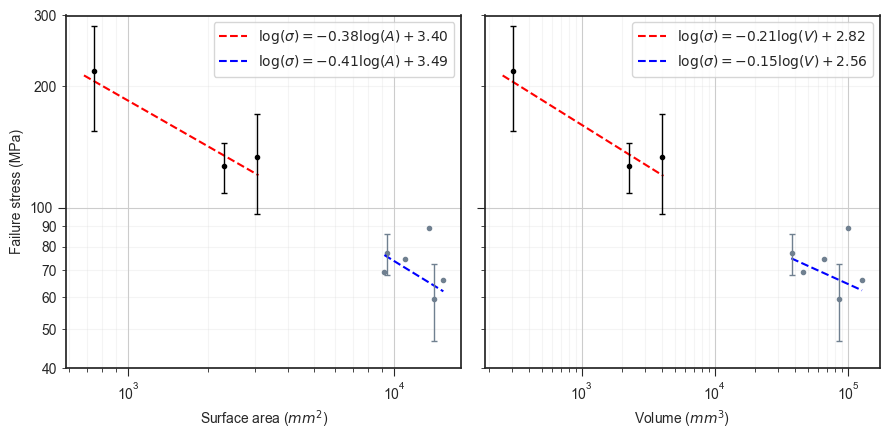

In [50]:
plot_strength_vs_size(gcc_data_clean, gcc_data_anal)

## Weibull size scaling (Stage 1)

Uses a linear regression method to perform size scaling and get in the ballpark

### All methods

Volume rsquared =  0.8015756628196857
Standard volume =  141.3716694115407 

Surface area rsquared =  0.629195055572629
Standard surface area =  565.4866776461628


<Figure size 640x480 with 0 Axes>

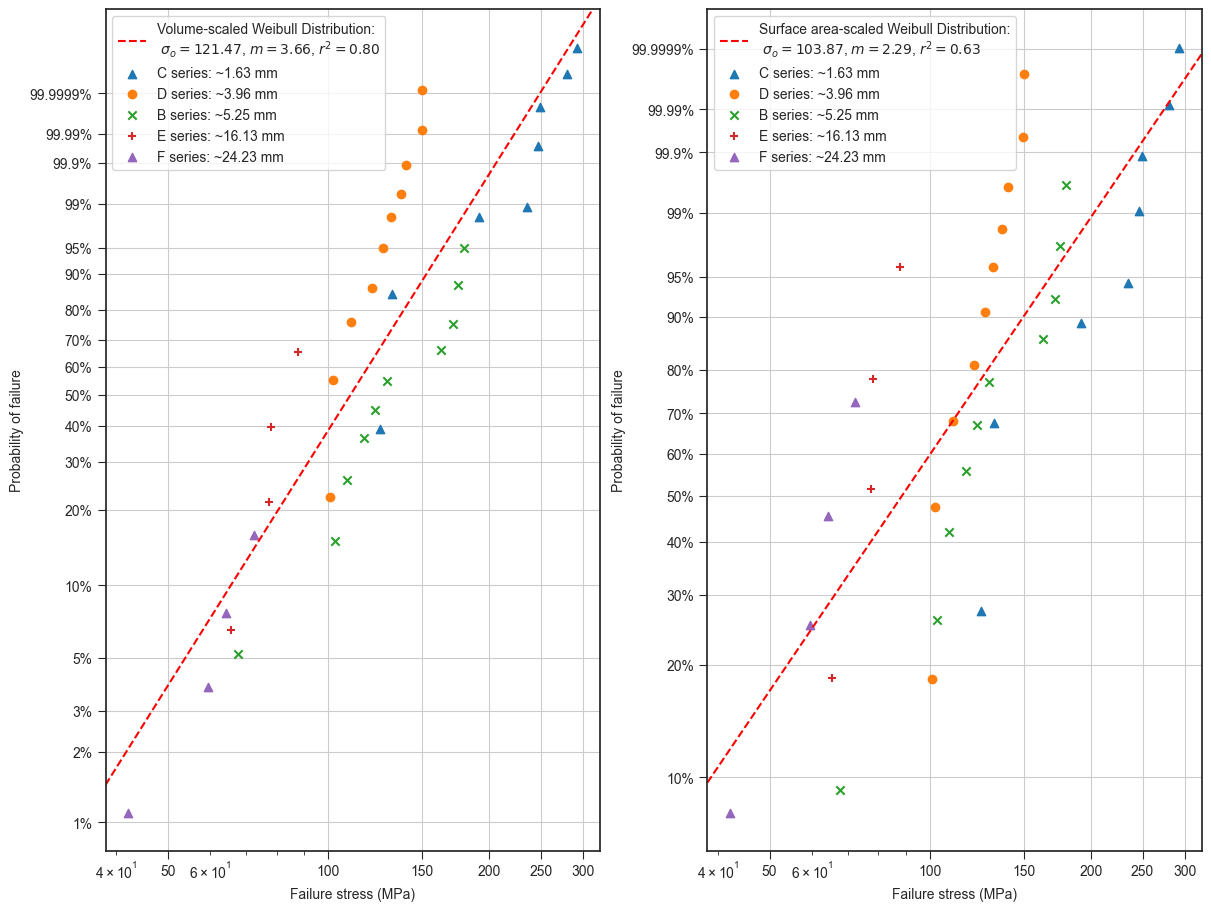

In [51]:
v_dist, sa_dist = plot_normalized_weibull(gcc_data_clean, gcc_data_anal)

### On vitrigraph samples

In [52]:
vitri_gcc_data_clean = gcc_data_clean.drop(gcc_data_clean[gcc_data_clean["series"].isin(["E", "F"])].index)
vitri_gcc_data_anal = gcc_data_anal.drop(gcc_data_anal[gcc_data_anal.index.isin(["E", "F"])].index)

In [53]:
print("Performing analysis on:")
print(vitri_gcc_data_clean["series"].unique().tolist())
print(vitri_gcc_data_anal.index.unique().to_list())

Performing analysis on:
['B', 'C', 'D', 'G', 'H', 'I', 'K']
['C', 'D', 'B', 'G', 'H', 'K', 'I']


Volume rsquared =  0.6589037288620384
Standard volume =  141.3716694115407 

Surface area rsquared =  0.6422805011728383
Standard surface area =  565.4866776461628


<Figure size 640x480 with 0 Axes>

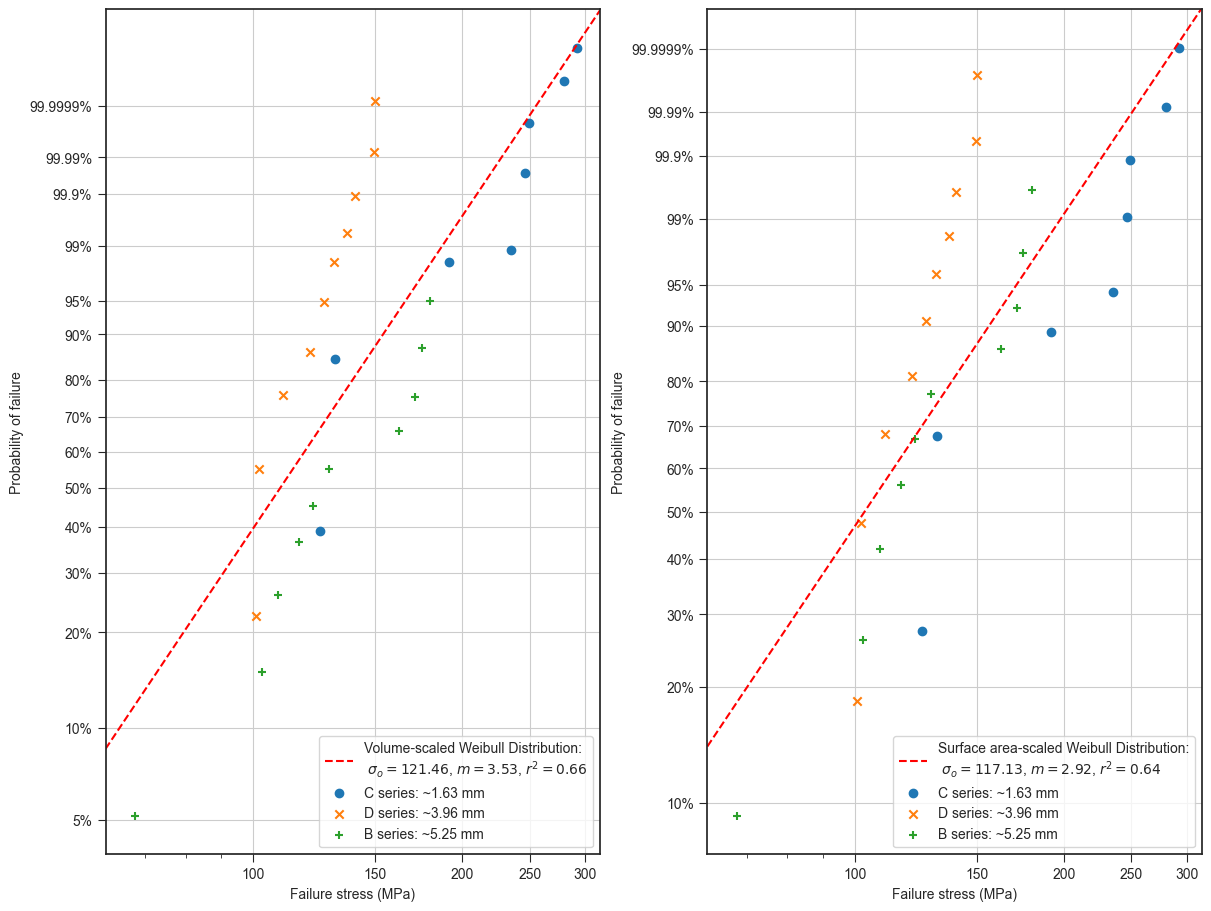

In [54]:
vitri_v_dist, vitri_sa_dist = plot_normalized_weibull(vitri_gcc_data_clean, vitri_gcc_data_anal)

### On cast samples

In [55]:
cast_gcc_data_clean = gcc_data_clean.loc[gcc_data_clean["series"].isin(["E", "F"])]
cast_gcc_data_anal = gcc_data_anal.loc[gcc_data_anal.index.isin(["E", "F"])]

In [56]:
print("Performing analysis on:")
print(cast_gcc_data_clean["series"].unique().tolist())
print(cast_gcc_data_anal.index.unique().to_list())

Performing analysis on:
['E', 'F']
['E', 'F']


Volume rsquared =  0.9224732271396122
Standard volume =  141.3716694115407 

Surface area rsquared =  0.832203490515216
Standard surface area =  565.4866776461628


<Figure size 640x480 with 0 Axes>

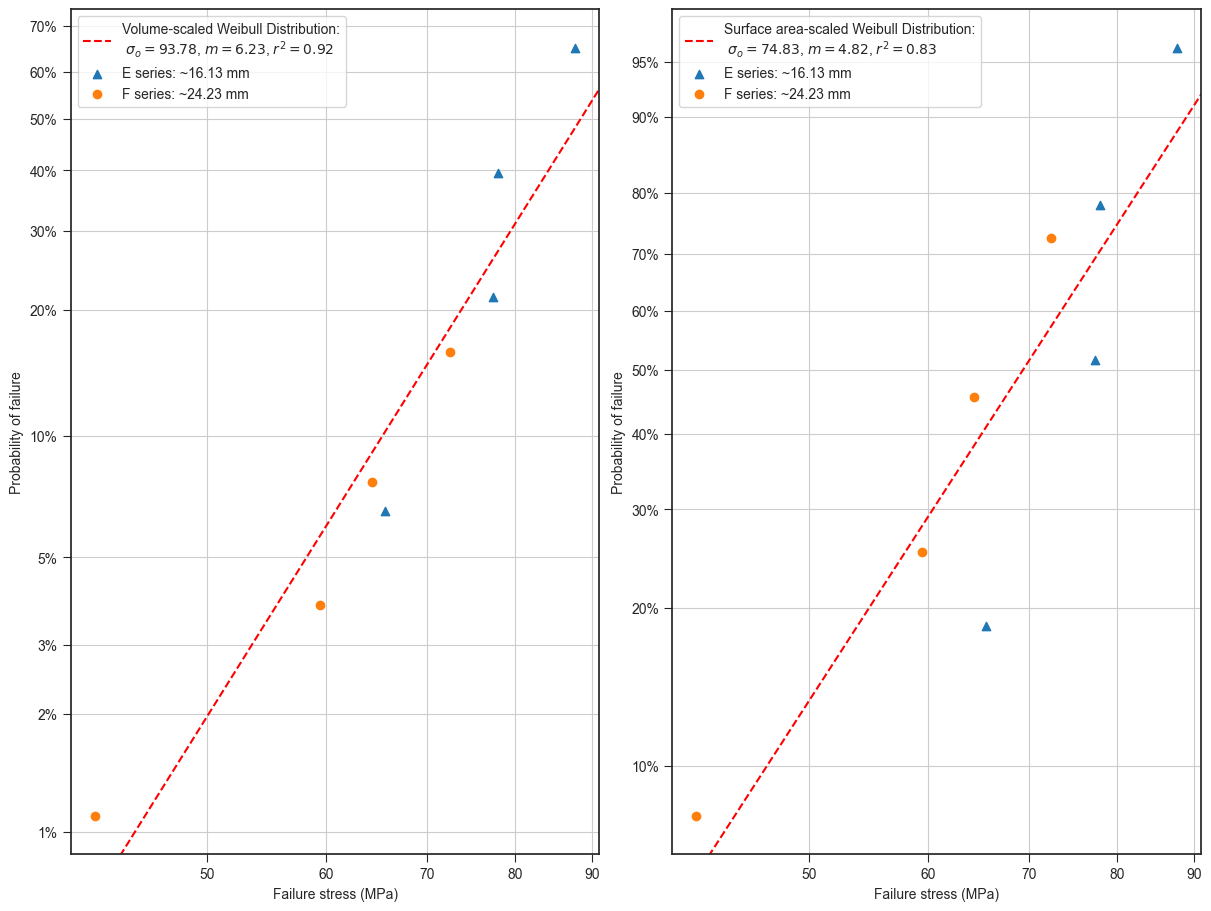

In [57]:
cast_v_dist, cast_sa_dist = plot_normalized_weibull(cast_gcc_data_clean, cast_gcc_data_anal)

## Plotting relation from pooled data

In [58]:
current_v_dist = v_dist
current_sa_dist = sa_dist

current_data = gcc_data_clean
current_data_anal = gcc_data_anal

## Generate a range of specimen geometry
diameter_vals = np.linspace(1,30, 100)
support_span = 185
load_span = 70

## Grab a design strength from the distribution created with pooled data
v_design_strength = current_v_dist.inverse_SF(design_prob)
v_char_strength = current_v_dist.alpha

sa_design_strength = current_sa_dist.inverse_SF(design_prob)
sa_char_strength = current_sa_dist.alpha

print("1% volume Design strength is: ", v_design_strength)
print("1% surface area Design strength is: ", sa_design_strength)

1% volume Design strength is:  53.92125172474091
1% surface area Design strength is:  28.332219589480534


In [59]:
## Scale the 1% design strength and characterisitic strength according to effective volume and surface area
standard_v = current_data["standard_gage_v"].iloc[0]
standard_sa = current_data["standard_gage_sa"].iloc[0]

gage_vol = cylinder_gage_V(diameter_vals, support_span)
eff_volume = effective_V(gage_vol, load_span, support_span, current_v_dist.beta)

gage_SA = cylinder_gage_SA(diameter_vals, support_span)
eff_SA = effective_SA(gage_SA, load_span, support_span, current_sa_dist.beta)

v_scaled_strength = v_design_strength * (standard_v / eff_volume) ** (1 / current_v_dist.beta)
sa_scaled_strength = sa_design_strength * (standard_sa / eff_SA) ** (1 / current_sa_dist.beta)

v_char_scaled_strength = v_char_strength * (standard_v / eff_volume) ** (1 / current_v_dist.beta)
sa_char_scaled_strength = sa_char_strength * (standard_sa / eff_SA) ** (1 / current_sa_dist.beta)

a =  -0.521721122565692
b =  3.086915000583117


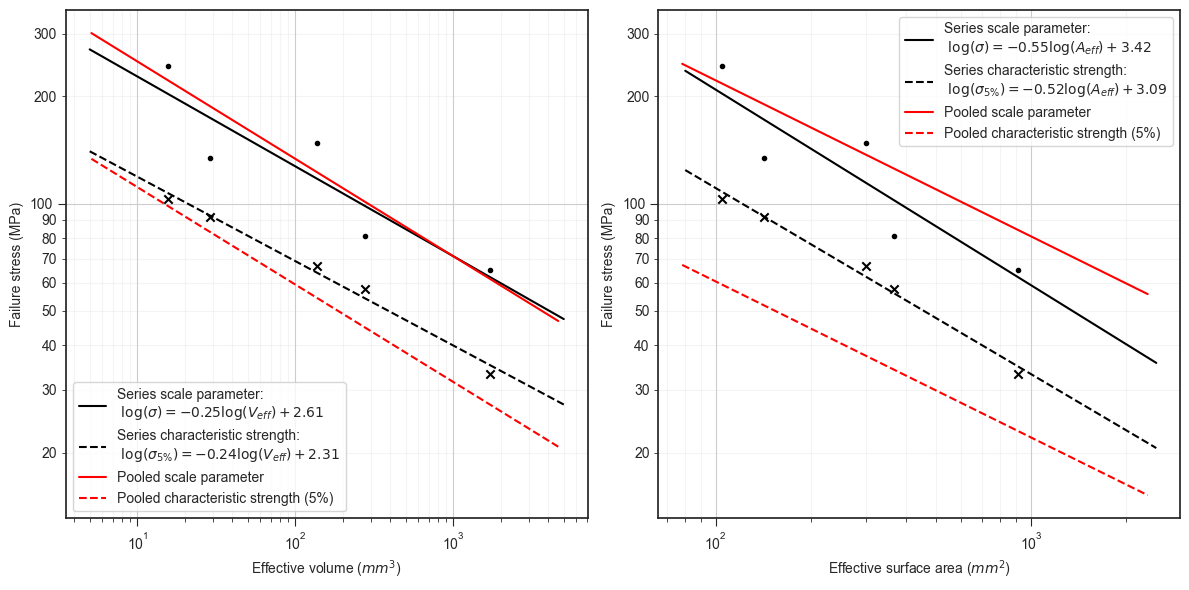

In [60]:
## Plot the range in a nice figure
fig, (ax_v, ax_sa) = plt.subplots(1,2, sharey="row")

fig.set_size_inches(12,6)

eff_vol_fit = current_data_anal["mean_effective_V"].dropna().to_numpy()
eff_SA_fit = current_data_anal["mean_effective_SA"].dropna().to_numpy()
design_strength_fit = current_data_anal["Design Strength"].dropna().to_numpy()
char_strength_fit = current_data_anal["char_strength"].dropna().to_numpy()

fit_line_fmt = "{}: \n $\\log(\\sigma_{}) = {:0.2f} \\log({}) + {:0.2f}$"

## Fitting lines of best fit to the individually determined values (black lines)
m, b = np.polyfit(np.log10(eff_vol_fit), np.log10(char_strength_fit), 1)
fit_x = np.linspace(5, 5000, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
ax_v.plot(fit_x, fit_y, "-k", label=fit_line_fmt.format("Series scale parameter","{}", m,"V_{{eff}}",b))

m, b = np.polyfit(np.log10(eff_SA_fit), np.log10(char_strength_fit), 1)
fit_x = np.linspace(80, 2500, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
ax_sa.plot(fit_x, fit_y, "-k", label=fit_line_fmt.format("Series scale parameter","{}", m,"A_{{eff}}",b))

m, b = np.polyfit(np.log10(eff_vol_fit), np.log10(design_strength_fit), 1)
fit_x = np.linspace(5, 5000, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
ax_v.plot(fit_x, fit_y, "--k", label=fit_line_fmt.format("Series characteristic strength","{5\\%}",m,"V_{{eff}}",b))

m, b = np.polyfit(np.log10(eff_SA_fit), np.log10(design_strength_fit), 1)
fit_x = np.linspace(80, 2500, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
ax_sa.plot(fit_x, fit_y, "--k", label=fit_line_fmt.format("Series characteristic strength","{5\\%}", m,"A_{{eff}}",b))

## Individual data points on plot
ax_v.scatter(data=current_data_anal, x="mean_effective_V", y="Design Strength", label=None, marker="x", color="k")
ax_v.scatter(data=current_data_anal, x="mean_effective_V", y="char_strength", label=None, marker=".", color="k")
ax_sa.scatter(data=current_data_anal, x="mean_effective_SA", y="Design Strength", label=None, marker="x", color="k")
ax_sa.scatter(data=current_data_anal, x="mean_effective_SA", y="char_strength", label=None, marker=".", color="k")

## Lines on plot
ax_v.plot(eff_volume, v_char_scaled_strength, "-r", label="Pooled scale parameter")
ax_v.plot(eff_volume, v_scaled_strength, "--r", label="Pooled characteristic strength (5%)")
ax_v.set_xlabel("Effective volume ($mm^3$)")
ax_v.set_ylabel(stress_label)

ax_sa.plot(eff_SA, sa_char_scaled_strength, "-r", label="Pooled scale parameter")
ax_sa.plot(eff_SA, sa_scaled_strength, "--r", label="Pooled characteristic strength (5%)")
ax_sa.set_xlabel("Effective surface area ($mm^2$)")
ax_sa.set_ylabel(stress_label)

## Figure formatting
ax_v.set_xscale("log")
ax_v.set_yscale("log")

ax_sa.set_xscale("log")
ax_sa.set_yscale("log")

plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

ax_v.legend()
ax_sa.legend()

ax_v.grid(visible=True, which='major', linestyle='-')
ax_v.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

ax_sa.grid(visible=True, which='major', linestyle='-')
ax_sa.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

ax_sa.tick_params(which="both", labelleft=True)

fig.tight_layout()

print("a = ", m)
print("b = ", b)

## Weibull size scaling (Stage 2)

Using maximum liklihood to fit the pooled data. Uses values from the previous analysis for initial value of optimisation

### Load unbiasing look up table

In [61]:
unbiasing_LUT = pd.read_excel("weibull_unbiasing_CI_factors.xlsx", sheet_name=None)

In [62]:
unbiasing_LUT.keys()

dict_keys(['UF', 'mod_CI', 'scale_t'])

In [63]:
unbiasing_LUT["mod_CI"]

,N,q_0.05,q_0.95
0,5,0.683,2.779
1,6,0.697,2.436
2,7,0.709,2.183
3,8,0.72,2.015
4,9,0.729,1.896
5,10,0.738,1.807
6,11,0.745,1.738
7,12,0.752,1.682
8,13,0.759,1.636
9,14,0.764,1.597


### Functions

In [64]:
weib_params = namedtuple("weib_params", ['sigma', "mod", "sample_size"])

In [65]:
weib_params(sigma=100, mod=5, sample_size=36)

weib_params(sigma=100, mod=5, sample_size=36)

In [66]:
def scaled_log_likelihood(weib_params, data, size_method):
    ## Returns a function of the size scaled maximum liklihood. Used for scipy.optimize.minimize
    if size_method == "V":
        size_scaler = effective_V
        size_label = "gage_V"
        standard_size_label = "standard_gage_v"
    elif size_method == "SA":
        size_scaler = effective_SA
        size_label = "gage_SA"
        standard_size_label = "standard_gage_sa"
    else:
        raise("Please choose a valid method, volume (V) or surface area (SA)")

    weib_sigma = weib_params[0]
    weib_mod = weib_params[1]

    standard_size = data[standard_size_label].iloc[0]

    n = 0

    sum_volumes = 0
    sum_strength = 0
    sum_exponential = 0

    for row in data.itertuples():
        volume_term = size_scaler(getattr(row, size_label), row.load_span, row.support_span, weib_mod) / standard_size
        frac_stress = row.fracture_stress

        sum_volumes += np.log(volume_term)
        sum_strength += np.log(frac_stress)
        sum_exponential += volume_term * (frac_stress / weib_sigma)**weib_mod

        n += 1

    sum_strength *= (weib_mod - 1)

    n_ln_m = n * np.log(weib_mod)

    n_m_ln_sigma = n * weib_mod * np.log(weib_sigma)
    
    return n_ln_m - n_m_ln_sigma + sum_volumes + sum_strength - sum_exponential


In [67]:
scaled_log_likelihood(weib_params(sigma=200, mod=5, sample_size=35), gcc_data_clean, "V")

np.float64(-248.75480998445224)

In [68]:
def minimize_log_likelihood(data, v_dist, sa_dist):
    likelihood_function_v = lambda x: -scaled_log_likelihood(x, data, "V")
    likelihood_function_sa = lambda x: -scaled_log_likelihood(x, data, "SA")
    weib_bounds = [(0, None),
                   (0, None)]
    
    v_guess = [v_dist.alpha, v_dist.beta]
    sa_guess = [sa_dist.alpha, sa_dist.beta]

    result_v = minimize(likelihood_function_v, v_guess, bounds=weib_bounds)
    result_sa = minimize(likelihood_function_sa, sa_guess, bounds=weib_bounds)

    print("Optimisation on volume:")
    print(result_v, "\n")

    print("Optimisation on surface area:")
    print(result_sa)

    sample_size = len(data.index)
    
    return weib_params(sigma=result_v.x[0], mod=result_v.x[1], sample_size=sample_size), weib_params(sigma=result_sa.x[0], mod=result_sa.x[1], sample_size=sample_size)

In [69]:
def calc_sample_geometry_v2(sample_data, analysis_data, v_weib_params, sa_weib_params):
    ### Calculate the required geometry for each value in the dataframe

    calc_V_helper = lambda row: effective_V(row["gage_V"], row["load_span"],  row["support_span"], v_weib_params.mod)
    calc_SA_helper = lambda row: effective_SA(row["gage_SA"], row["load_span"],  row["support_span"], sa_weib_params.mod)

    ## Effective V and SA for individual samples
    sample_data["effective_V"] = sample_data.apply(calc_V_helper, axis=1)
    sample_data["effective_SA"] = sample_data.apply(calc_SA_helper, axis=1)

    # calc_V_helper = lambda row: effective_V(row["mean_gage_V"], row["load_span"],  row["support_span"], v_weib_params.mod)
    # calc_SA_helper = lambda row: effective_SA(row["mean_gage_SA"], row["load_span"],  row["support_span"], sa_weib_params.mod)

    # ## Effective V and SA for series
    # analysis_data["mean_effective_V"] = analysis_data.apply(calc_V_helper, axis=1)
    # analysis_data["mean_effective_SA"] = analysis_data.apply(calc_SA_helper, axis=1)

    return sample_data, analysis_data

In [70]:
def strength_normalize(sample_data, v_weib_params, sa_weib_params, standard_v, standard_sa):
    v_strength_scale_func = lambda row: row["fracture_stress"] * (row["effective_V"] / standard_v) ** (1/v_weib_params.mod)
    sa_strength_scale_func = lambda row: row["fracture_stress"] * (row["effective_SA"] / standard_sa) ** (1/sa_weib_params.mod)

    sample_data["scaled_strength_V"] = sample_data.apply(v_strength_scale_func, axis=1)
    sample_data["scaled_strength_SA"] = sample_data.apply(sa_strength_scale_func, axis=1)

    return sample_data

In [71]:
def plot_normalized_weibull_stage_2(data, analysed_data, v_weib_params, sa_weib_params):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    spacing = 0.05

    ## Work out limits for scaling
    x_max = np.log10(data["fracture_stress"].max())
    x_min = np.log10(data["fracture_stress"].min())

    x_range = x_max - x_min
    
    xlims = [10 **(x_min - x_range * spacing),
             10 **(x_max + x_range * spacing)]
    
    ## For volume
    y_max = axes_transforms.weibull_forward(data["Fail Prob V Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob V Adj"].min())

    y_range = y_max - y_min
    
    v_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
               axes_transforms.weibull_inverse(y_max + y_range * spacing)]
    
    y_max = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob SA Adj"].min())

    y_range = y_max - y_min
    
    sa_ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
                axes_transforms.weibull_inverse(y_max + y_range * spacing)]
    
    ylims = [np.min([v_ylims[0], sa_ylims[0]]),
             np.min([np.max([v_ylims[1], sa_ylims[1]]), 1-9e-17])]

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_weib_params.sigma, beta=v_weib_params.mod)
    sa_dist = Weibull_Distribution(alpha=sa_weib_params.sigma, beta=sa_weib_params.mod)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(xlims[0], xlims[1], 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(xlims[0], xlims[1], 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    v_y_true = []
    v_y_pred = []

    sa_y_true = []
    sa_y_pred = []

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="fracture_stress", y="Fail Prob V Adj", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="fracture_stress", y="Fail Prob SA Adj", label=legend_text, marker=marker_symb)

        v_y_true.extend(plot_data["Fail Prob V Adj"].tolist())
        v_y_pred.extend(v_dist.CDF(xvals=plot_data["fracture_stress"].tolist(), show_plot=False))

        sa_y_true.extend(plot_data["Fail Prob SA Adj"].tolist())
        sa_y_pred.extend(sa_dist.CDF(xvals=plot_data["fracture_stress"].tolist(), show_plot=False))

    v_r2 = r2_score(v_y_true, v_y_pred)
    sa_r2 = r2_score(sa_y_true, sa_y_pred)

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$, $r^2 = {:.2f}$"

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_weib_params.sigma, v_weib_params.mod, v_r2))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_weib_params.sigma, sa_weib_params.mod, sa_r2))


    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    ax_v.set_xlim(xlims)
    ax_v.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")
    # plt.xlim(plt.ylim([0.01, 0.99999]))

    plt.sca(ax_sa)
    ax_sa.set_xlim(xlims)
    ax_sa.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(14,7)

    print("MLE scaling method:", "\n")
    
    print("Scaled on volume:")
    print("Standard volume = ", data["standard_gage_v"].iloc[0])
    print("Weibull Scale = ", v_weib_params.sigma)
    print("Weibull Modulus = ", v_weib_params.mod, "\n")

    print("Scaled on surface area:")
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])
    print("Weibull Scale = ", sa_weib_params.sigma)
    print("Weibull Modulus = ", sa_weib_params.mod)

    return v_dist, sa_dist

In [72]:
def plot_strength_normalized_weibull(data, analysed_data, v_weib_params, sa_weib_params):
    ### Make a big fancy figure of normalised data with colour coded sample series
    normalise_unique_series = analysed_data.dropna().index.unique()

    spacing = 0.05

    ## Work out limits for scaling
    ## Volume x:
    x_max = np.log10(data["scaled_strength_V"].max())
    x_min = np.log10(data["scaled_strength_V"].min())

    x_range = x_max - x_min
    
    v_xlims = [10 **(x_min - x_range * spacing),
               10 **(x_max + x_range * spacing)]
    
    ## Surface area x
    x_max = np.log10(data["scaled_strength_SA"].max())
    x_min = np.log10(data["scaled_strength_SA"].min())

    x_range = x_max - x_min
    
    sa_xlims = [10 **(x_min - x_range * spacing),
               10 **(x_max + x_range * spacing)]

    # ## For volume
    y_max = axes_transforms.weibull_forward(data["Fail Prob"].max())
    y_min = axes_transforms.weibull_forward(data["Fail Prob"].min())

    y_range = y_max - y_min
    
    ylims = [axes_transforms.weibull_inverse(y_min - y_range * spacing),
             axes_transforms.weibull_inverse(y_max + y_range * spacing)]

    ## Make distributions according to parameters
    v_dist = Weibull_Distribution(alpha=v_weib_params.sigma, beta=v_weib_params.mod)
    sa_dist = Weibull_Distribution(alpha=sa_weib_params.sigma, beta=sa_weib_params.mod)
    
    ## Get values for plotting the distribution line
    v_dist_x = np.linspace(v_xlims[0], v_xlims[1], 200)
    v_dist_y = v_dist.CDF(xvals=v_dist_x, show_plot=False)

    sa_dist_x = np.linspace(sa_xlims[0], sa_xlims[1], 200)
    sa_dist_y = sa_dist.CDF(xvals=sa_dist_x, show_plot=False)

    ## Plot the distribution lines
    plt.clf()
    fig, (ax_v, ax_sa) = plt.subplots(1,2, layout="constrained")

    fit_label_fmt = "{}-scaled Weibull Distribution:\n $\\sigma_o = {:.2f}$, $m = {:.2f}$"

    ax_v.plot(v_dist_x, v_dist_y, "--r", label=fit_label_fmt.format("Volume", v_weib_params.sigma, v_weib_params.mod))
    ax_sa.plot(sa_dist_x, sa_dist_y, "--r", label=fit_label_fmt.format("Surface area", sa_weib_params.sigma, sa_weib_params.mod))

    ## Put a scatter plot of each series on the figure, with nice colour and marker coding
    for i, letter in enumerate(normalise_unique_series):
        plot_data = data.loc[data["series"] == letter]

        marker_symb = next(marker_cycler)
        avg_diameter = analysed_data.loc[letter, "fracture_diameter_mean"]
        legend_text = "%s series: ~%.2f mm" % (letter, avg_diameter)

        ax_v.scatter(data=plot_data, x="scaled_strength_V", y="Fail Prob", label=legend_text, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="scaled_strength_SA", y="Fail Prob", label=legend_text, marker=marker_symb)

    ## Use some funky functions from the reliability library to scale the weibull distribution to a straight line
    ax_v.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_v.set_xscale("log")

    ax_sa.set_yscale('function', functions=(axes_transforms.weibull_forward, axes_transforms.weibull_inverse))
    ax_sa.set_xscale("log")

    ## Using reliability library functions to format the axes correctly
    plt.sca(ax_v)
    ax_v.set_xlim(v_xlims)
    ax_v.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")
    # plt.xlim(plt.ylim([0.01, 0.99999]))

    plt.sca(ax_sa)
    ax_sa.set_xlim(sa_xlims)
    ax_sa.set_ylim(ylims)
    probability_plot_xyticks()
    # probability_plot_xylims(v_dist_x, v_dist_y, "weibull")

    ## Labelling and formatting
    ax_v.set_xlabel(stress_label)
    ax_v.set_ylabel("Probability of failure")

    ax_sa.set_xlabel(stress_label)
    ax_sa.set_ylabel("Probability of failure")

    ax_v.grid(zorder=2)
    ax_v.set_axisbelow(True)
    ax_v.legend()

    ax_sa.grid(zorder=2)
    ax_sa.set_axisbelow(True)
    ax_sa.legend()

    plt.gcf().set_size_inches(10, 5)

    print("MLE scaling method:", "\n")
    
    print("Scaled on volume:")
    print("Standard volume = ", data["standard_gage_v"].iloc[0])
    print("Weibull Scale = ", v_weib_params.sigma)
    print("Weibull Modulus = ", v_weib_params.mod, "\n")

    print("Scaled on surface area:")
    print("Standard surface area = ", data["standard_gage_sa"].iloc[0])
    print("Weibull Scale = ", sa_weib_params.sigma)
    print("Weibull Modulus = ", sa_weib_params.mod)

    return v_dist, sa_dist

In [73]:
def unbias_mod(LUT, weib_params):
    mod_unbiasing_factors = LUT["UF"]
    if weib_params.sample_size in mod_unbiasing_factors.N.values:
        uf = mod_unbiasing_factors.loc[mod_unbiasing_factors["N"] == weib_params.sample_size, "UF"].values[0]
    elif weib_params.sample_size <= mod_unbiasing_factors.N.max():
        upper = mod_unbiasing_factors.iloc[mod_unbiasing_factors.loc[mod_unbiasing_factors["N"] > weib_params.sample_size, "UF"].idxmin()]
        lower = mod_unbiasing_factors.iloc[mod_unbiasing_factors.loc[mod_unbiasing_factors["N"] < weib_params.sample_size, "UF"].idxmax()]

        uf = np.interp(weib_params.sample_size, [lower["N"], upper['N']], [lower["UF"], upper['UF']])
    else:
        raise ValueError("Sample size not in the range of look up table")
    
    return weib_params._replace(mod=weib_params.mod * uf)

In [74]:
unbias_mod(unbiasing_LUT, weib_params(sigma=200, mod=5, sample_size=35))

weib_params(sigma=200, mod=np.float64(4.805), sample_size=35)

In [75]:
def calc_CI(LUT, weib_params):
    mod_CI_LUT = LUT['mod_CI']
    scale_CI_LUT = LUT['scale_t']

    if weib_params.sample_size in mod_CI_LUT.N.values:
        CI_factors = mod_CI_LUT.loc[mod_CI_LUT["N"] == weib_params.sample_size]
        
        q_0_05 = CI_factors["q_0.05"].values[0]
        q_0_95 = CI_factors["q_0.95"].values[0]

    elif weib_params.sample_size <= mod_CI_LUT.N.max():
        upper = mod_CI_LUT.iloc[mod_CI_LUT.loc[mod_CI_LUT["N"] > weib_params.sample_size]["N"].idxmin()]
        lower = mod_CI_LUT.iloc[mod_CI_LUT.loc[mod_CI_LUT["N"] < weib_params.sample_size]["N"].idxmax()]

        q_0_05 = np.interp(weib_params.sample_size, [lower["N"], upper['N']], [lower["q_0.05"], upper["q_0.05"]])
        q_0_95 = np.interp(weib_params.sample_size, [lower["N"], upper['N']], [lower["q_0.95"], upper["q_0.95"]])
    else:
        raise ValueError("Sample size not in the range of look up table")
    
    mod_CI = (weib_params.mod/q_0_95, weib_params.mod/q_0_05)

    if weib_params.sample_size in scale_CI_LUT.N.values:
        t_factors = scale_CI_LUT.loc[scale_CI_LUT["N"] == weib_params.sample_size]
        
        t_0_05 = t_factors["t_0.05"].values[0]
        t_0_95 = t_factors["t_0.95"].values[0]

    elif weib_params.sample_size <= scale_CI_LUT.N.max():
        upper = scale_CI_LUT.iloc[scale_CI_LUT.loc[scale_CI_LUT["N"] > weib_params.sample_size]["N"].idxmin()]
        lower = scale_CI_LUT.iloc[scale_CI_LUT.loc[scale_CI_LUT["N"] < weib_params.sample_size]["N"].idxmax()]

        t_0_05 = np.interp(weib_params.sample_size, [lower["N"], upper['N']], [lower["t_0.05"], upper["t_0.05"]])
        t_0_95 = np.interp(weib_params.sample_size, [lower["N"], upper['N']], [lower["t_0.95"], upper["t_0.95"]])
    else:
        raise ValueError("Sample size not in the range of look up table")
    
    scale_CI = (weib_params.sigma * np.exp(-t_0_95/weib_params.mod), weib_params.sigma * np.exp(-t_0_05/weib_params.mod))

    return scale_CI, mod_CI

In [76]:
calc_CI(unbiasing_LUT, weib_params(sigma=200, mod=5, sample_size=36))

((np.float64(188.27758062038663), np.float64(212.57978283743904)),
 (np.float64(3.863987635239567), np.float64(6.009615384615385)))

### Make dataframes for separate scaling procedures

In [77]:
## Remove the size scaling data from the less accurate regression method
drop_cols = ["char_strength",
             "weibull_modulus",
             "effective_V",
             "effective_SA",
             "Fail Prob V Adj",
             "Fail Prob SA Adj"]

gcc_data_v2 = gcc_data_clean.drop(drop_cols, axis=1)

# drop_anal_cols = ["char_strength",
#                   "char_strength_95%_upper",
#                   "char_strength_95%_lower",
#                   "weibull_modulus",
#                   "weibull_modulus_95%_upper",
#                   "weibull_modulus_95%_lower",
#                   "Design Strength",
#                   "mean_effective_V",
#                   "mean_effective_SA"]

# gcc_data_anal_v2 = gcc_data_anal.drop(drop_anal_cols, axis=1)
gcc_data_anal_v2 = gcc_data_anal.copy()

In [78]:
vitri_gcc_data_v2 = gcc_data_v2.drop(gcc_data_v2[gcc_data_v2["series"].isin(["E", "F", "G", "H", "I", "K"])].index)
vitri_gcc_data_anal_v2 = gcc_data_anal_v2.drop(gcc_data_anal_v2[gcc_data_anal_v2.index.isin(["E", "F", "G", "H", "I", "K"])].index)

cast_gcc_data_v2 = gcc_data_v2.loc[gcc_data_v2["series"].isin(["E", "F"])]
cast_gcc_data_anal_v2 = gcc_data_anal_v2.loc[gcc_data_anal_v2.index.isin(["E", "F"])]

### All methods

In [79]:
weib_params_v, weib_params_sa = minimize_log_likelihood(gcc_data_v2, v_dist, sa_dist)

Optimisation on volume:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 190.49230791912183
        x: [ 1.278e+02  4.296e+00]
      nit: 12
      jac: [ 8.527e-06  9.948e-05]
     nfev: 42
     njev: 14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

Optimisation on surface area:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 199.64372122705498
        x: [ 1.114e+02  2.981e+00]
      nit: 15
      jac: [-1.705e-05 -1.137e-05]
     nfev: 48
     njev: 16
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [80]:
ub_weib_params_v = unbias_mod(unbiasing_LUT, weib_params_v)
ub_weib_params_sa = unbias_mod(unbiasing_LUT, weib_params_sa)

print("Unbiasing the weibull modulus:")
print("Volume: %.2f -> %.2f" % (weib_params_v.mod, ub_weib_params_v.mod))
print("Surface area: %.2f -> %.2f" % (weib_params_sa.mod, ub_weib_params_sa.mod))

Unbiasing the weibull modulus:
Volume: 4.30 -> 4.15
Surface area: 2.98 -> 2.88


In [81]:
gcc_data_v2, gcc_data_anal_v2 = calc_sample_geometry_v2(gcc_data_v2, gcc_data_anal_v2, weib_params_v, weib_params_sa)
gcc_data_v2 = normalize_data(gcc_data_v2, standard_v, standard_sa)
gcc_data_v2 = strength_normalize(gcc_data_v2, weib_params_v, weib_params_sa, standard_v, standard_sa)

In [82]:
gcc_data_v2

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Prob V Adj,Fail Prob SA Adj,scaled_strength_V,scaled_strength_SA
0,B1,46.7887,67.761,5.23,...,0.0617715,0.0804837,64.4141,57.4495
1,B2,85.8979,170.977,5.28,...,0.815627,0.894208,163.254,145.422
2,B3,54.1228,102.886,5.3,...,0.178582,0.230753,98.4112,87.619
3,B4,64.6418,122.189,5.31,...,0.513703,0.618342,116.978,104.124
4,B5,78.9588,174.763,5.09,...,0.917072,0.958776,164.046,146.826
5,B6,57.2761,116.623,5.18,...,0.420672,0.509089,110.368,98.5583
6,B7,68.1001,128.726,5.31,...,0.618226,0.723778,123.236,109.694
7,B8,80.9788,162.4,5.24,...,0.727479,0.819867,154.516,137.775
8,B9,56.073,108.539,5.22,...,0.301614,0.375936,103.086,91.9631
9,B10,92.3955,179.794,5.32,...,0.972649,0.991914,172.276,153.308


MLE scaling method: 

Scaled on volume:
Standard volume =  141.3716694115407
Weibull Scale =  127.8236057524477
Weibull Modulus =  4.295652592256014 

Scaled on surface area:
Standard surface area =  565.4866776461628
Weibull Scale =  111.38988236456277
Weibull Modulus =  2.9813010520277876


<Figure size 640x480 with 0 Axes>

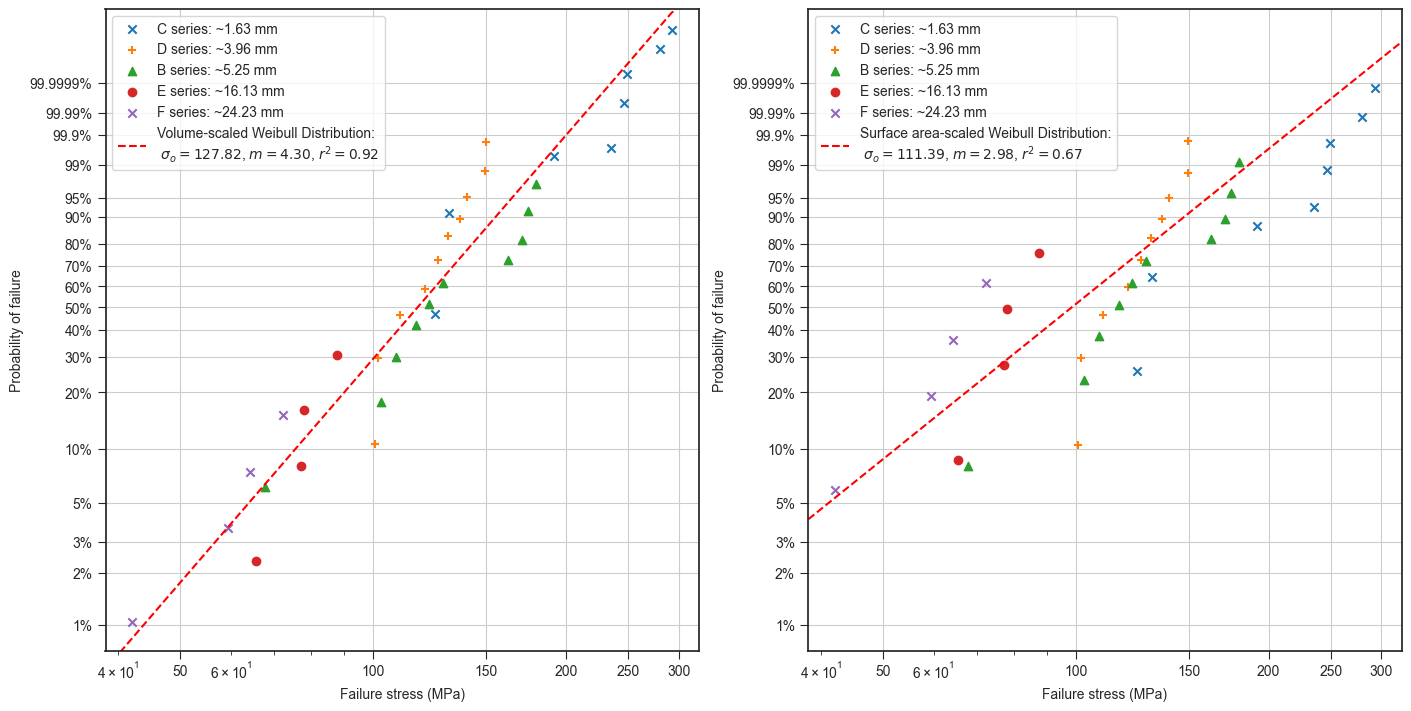

In [83]:
v_dist, sa_dist = plot_normalized_weibull_stage_2(gcc_data_v2, gcc_data_anal_v2, weib_params_v, weib_params_sa)

MLE scaling method: 

Scaled on volume:
Standard volume =  141.3716694115407
Weibull Scale =  127.8236057524477
Weibull Modulus =  4.295652592256014 

Scaled on surface area:
Standard surface area =  565.4866776461628
Weibull Scale =  111.38988236456277
Weibull Modulus =  2.9813010520277876


(<reliability.Distributions.Weibull_Distribution at 0x19376e30640>,
 <reliability.Distributions.Weibull_Distribution at 0x19376e31940>)

<Figure size 640x480 with 0 Axes>

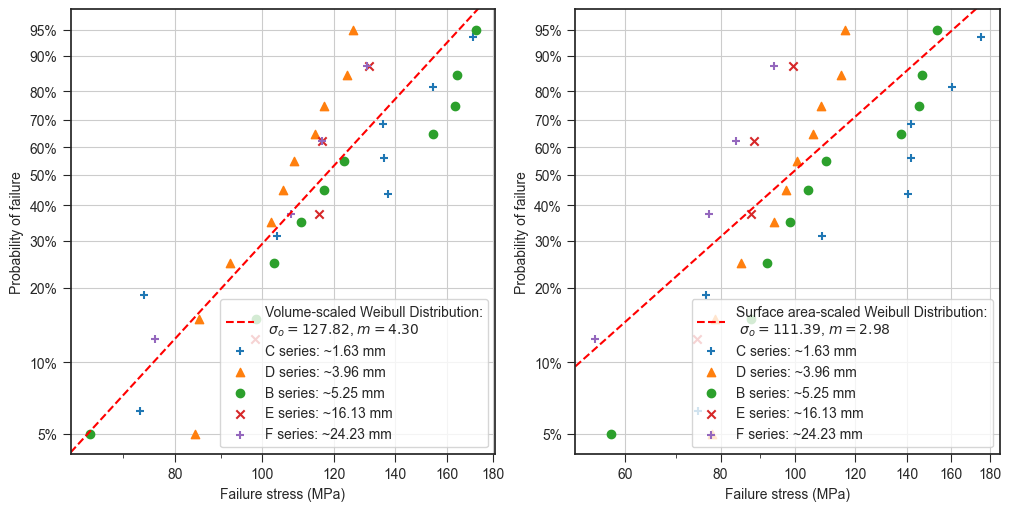

In [84]:
plot_strength_normalized_weibull(gcc_data_v2, gcc_data_anal_v2, weib_params_v, weib_params_sa)

### Vitrigraph method

In [85]:
vitri_weib_params_v, vitri_weib_params_sa = minimize_log_likelihood(vitri_gcc_data_v2, vitri_v_dist, vitri_sa_dist)

Optimisation on volume:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 141.76300936013183
        x: [ 1.297e+02  4.304e+00]
      nit: 8
      jac: [ 2.842e-06  1.137e-05]
     nfev: 33
     njev: 11
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

Optimisation on surface area:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 144.62832947694275
        x: [ 1.240e+02  3.476e+00]
      nit: 13
      jac: [ 0.000e+00  1.904e-04]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [86]:
ub_vitri_weib_params_v = unbias_mod(unbiasing_LUT, vitri_weib_params_v)
ub_vitri_weib_params_sa = unbias_mod(unbiasing_LUT, vitri_weib_params_sa)

print("Unbiasing the weibull modulus:")
print("Volume: %.2f -> %.2f" % (vitri_weib_params_v.mod, ub_vitri_weib_params_v.mod))
print("Surface area: %.2f -> %.2f" % (vitri_weib_params_sa.mod, ub_vitri_weib_params_sa.mod))

Unbiasing the weibull modulus:
Volume: 4.30 -> 4.09
Surface area: 3.48 -> 3.31


In [87]:
vitri_gcc_data_v2, vitri_gcc_data_anal_v2 = calc_sample_geometry_v2(vitri_gcc_data_v2, vitri_gcc_data_anal_v2, vitri_weib_params_v, vitri_weib_params_sa)
vitri_gcc_data_v2 = normalize_data(vitri_gcc_data_v2, standard_v, standard_sa)
vitri_gcc_data_v2 = strength_normalize(vitri_gcc_data_v2, vitri_weib_params_v, vitri_weib_params_sa, standard_v, standard_sa)

In [88]:
vitri_gcc_data_v2

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Prob V Adj,Fail Prob SA Adj,scaled_strength_V,scaled_strength_SA
0,B1,46.7887,67.761,5.23,...,0.0619208,0.0884035,64.3829,57.1778
1,B2,85.8979,170.977,5.28,...,0.816403,0.916077,163.174,144.669
2,B3,54.1228,102.886,5.3,...,0.178985,0.251279,98.3625,87.1494
3,B4,64.6418,122.189,5.31,...,0.514577,0.654421,116.919,103.556
4,B5,78.9588,174.763,5.09,...,0.917586,0.970326,163.97,146.321
5,B6,57.2761,116.623,5.18,...,0.42146,0.543809,110.316,98.1373
6,B7,68.1001,128.726,5.31,...,0.619142,0.758089,123.175,109.097
7,B8,80.9788,162.4,5.24,...,0.728361,0.849045,154.441,137.112
8,B9,56.073,108.539,5.22,...,0.30224,0.405546,103.036,91.5367
9,B10,92.3955,179.794,5.32,...,0.972894,0.995079,172.19,152.459


MLE scaling method: 

Scaled on volume:
Standard volume =  141.3716694115407
Weibull Scale =  129.72709017689272
Weibull Modulus =  4.3037867418281985 

Scaled on surface area:
Standard surface area =  565.4866776461628
Weibull Scale =  124.01310752275678
Weibull Modulus =  3.4758865684366196


<Figure size 640x480 with 0 Axes>

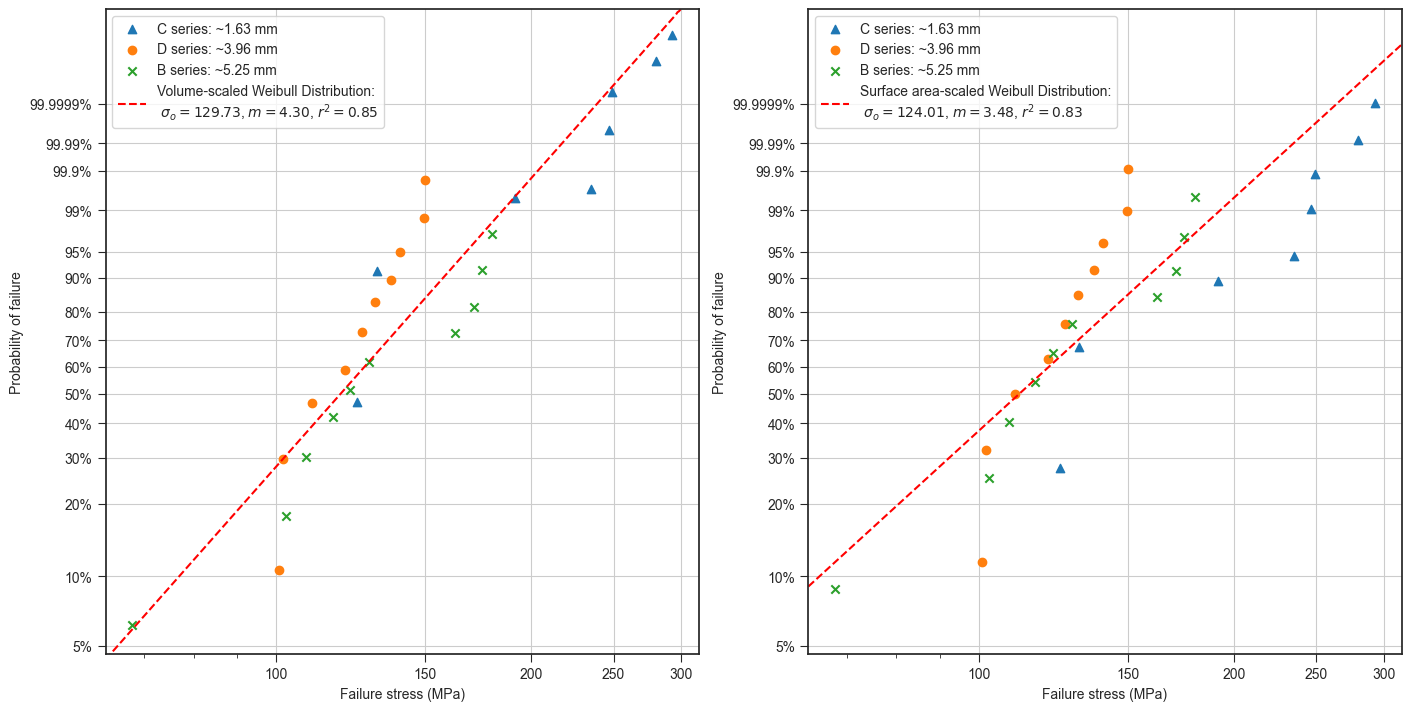

In [89]:
vitri_v_dist, vitri_sa_dist = plot_normalized_weibull_stage_2(vitri_gcc_data_v2, vitri_gcc_data_anal_v2, vitri_weib_params_v, vitri_weib_params_sa)

MLE scaling method: 

Scaled on volume:
Standard volume =  141.3716694115407
Weibull Scale =  129.72709017689272
Weibull Modulus =  4.3037867418281985 

Scaled on surface area:
Standard surface area =  565.4866776461628
Weibull Scale =  124.01310752275678
Weibull Modulus =  3.4758865684366196


(<reliability.Distributions.Weibull_Distribution at 0x1937b9408a0>,
 <reliability.Distributions.Weibull_Distribution at 0x1937b940770>)

<Figure size 640x480 with 0 Axes>

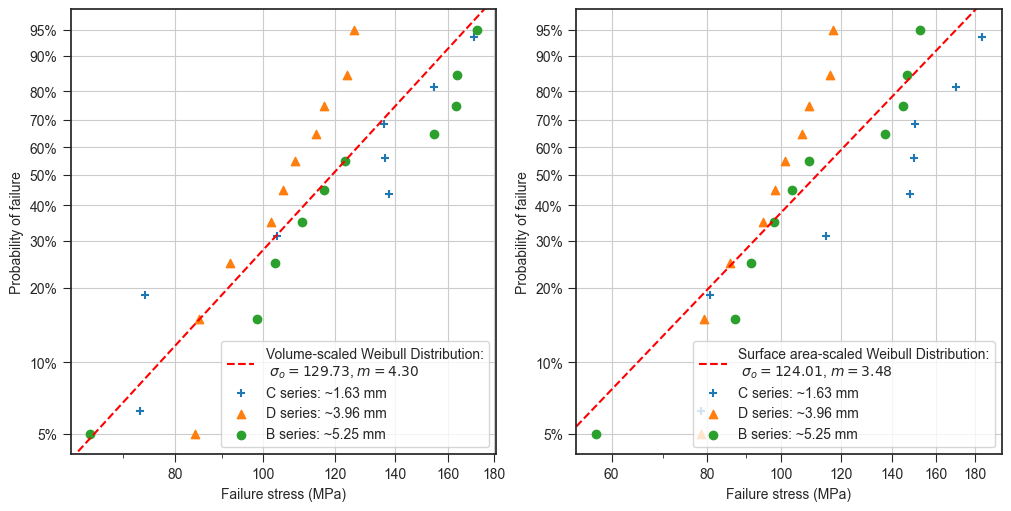

In [90]:
plot_strength_normalized_weibull(vitri_gcc_data_v2, vitri_gcc_data_anal_v2, vitri_weib_params_v, vitri_weib_params_sa)

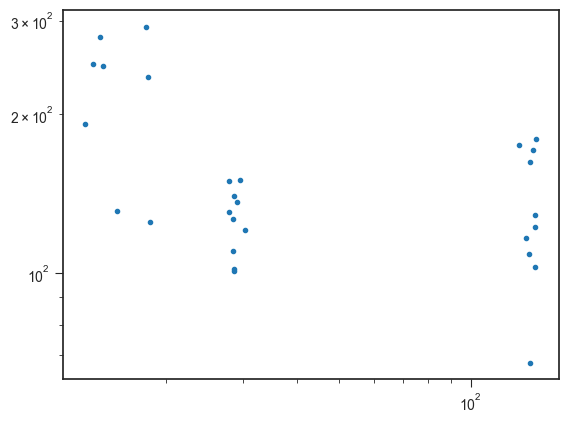

In [91]:
fig, ax_v = plt.subplots(1,1)

ax_v.scatter(data=vitri_gcc_data_clean, x="effective_V", y="fracture_stress")

ax_v.set_xscale("log")
ax_v.set_yscale("log")

### Cast method

In [92]:
cast_weib_params_v, cast_weib_params_sa = minimize_log_likelihood(cast_gcc_data_v2, cast_v_dist, cast_sa_dist)

Optimisation on volume:
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 30.04128435611387
        x: [ 8.703e+01  7.205e+00]
      nit: 13
      jac: [-5.684e-06 -1.137e-05]
     nfev: 60
     njev: 20
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64> 

Optimisation on surface area:
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 30.71829598935519
        x: [ 7.209e+01  6.757e+00]
      nit: 8
      jac: [-2.842e-06  5.684e-06]
     nfev: 27
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [93]:
ub_cast_weib_params_v = unbias_mod(unbiasing_LUT, cast_weib_params_v)
ub_cast_weib_params_sa = unbias_mod(unbiasing_LUT, cast_weib_params_sa)


print("Unbiasing the weibull modulus:")
print("Volume: %.2f -> %.2f" % (cast_weib_params_v.mod, ub_cast_weib_params_v.mod))
print("Surface area: %.2f -> %.2f" % (cast_weib_params_sa.mod, ub_cast_weib_params_sa.mod))

Unbiasing the weibull modulus:
Volume: 7.20 -> 5.91
Surface area: 6.76 -> 5.54


In [94]:
cast_gcc_data_v2, cast_gcc_data_anal_v2 = calc_sample_geometry_v2(cast_gcc_data_v2, cast_gcc_data_anal_v2, cast_weib_params_v, cast_weib_params_sa)
cast_gcc_data_v2 = normalize_data(cast_gcc_data_v2, standard_v, standard_sa)
cast_gcc_data_v2 = strength_normalize(cast_gcc_data_v2, cast_weib_params_v, cast_weib_params_sa, standard_v, standard_sa)

C:\Users\shawm\AppData\Local\Temp\ipykernel_26256\1206950720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data["effective_V"] = sample_data.apply(calc_V_helper, axis=1)
C:\Users\shawm\AppData\Local\Temp\ipykernel_26256\1206950720.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data["effective_SA"] = sample_data.apply(calc_SA_helper, axis=1)
C:\Users\shawm\AppData\Local\Temp\ipykernel_26256\3956572183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [95]:
cast_gcc_data_v2

,sample,fracture_load,fracture_stress,fracture_diameter,...,Fail Prob V Adj,Fail Prob SA Adj,scaled_strength_V,scaled_strength_SA
32,E1,877.638,77.9804,16.08,...,0.315797,0.717669,88.9661,75.1017
33,E2,871.381,65.5725,16.2,...,0.0496292,0.157093,74.9647,63.2213
34,E3,1064.55,87.7326,16.15,...,0.549597,0.93072,100.213,84.5481
35,E4,875.259,77.3287,16.09,...,0.166087,0.454276,88.2378,74.4809
36,F1,1748.97,42.1192,24.2,...,0.0225527,0.108102,53.8271,43.094
37,F2,3263.78,59.4176,24.3,...,0.0765424,0.330363,76.021,60.8299
38,F3,2743.16,72.3982,24.1,...,0.301054,0.832866,92.4165,74.0284
39,F4,2537.04,64.3262,24.3,...,0.153104,0.566936,82.3012,65.8551


MLE scaling method: 

Scaled on volume:
Standard volume =  141.3716694115407
Weibull Scale =  87.02801656272197
Weibull Modulus =  7.204579303097992 

Scaled on surface area:
Standard surface area =  565.4866776461628
Weibull Scale =  72.09084939019621
Weibull Modulus =  6.757112000380746


<Figure size 640x480 with 0 Axes>

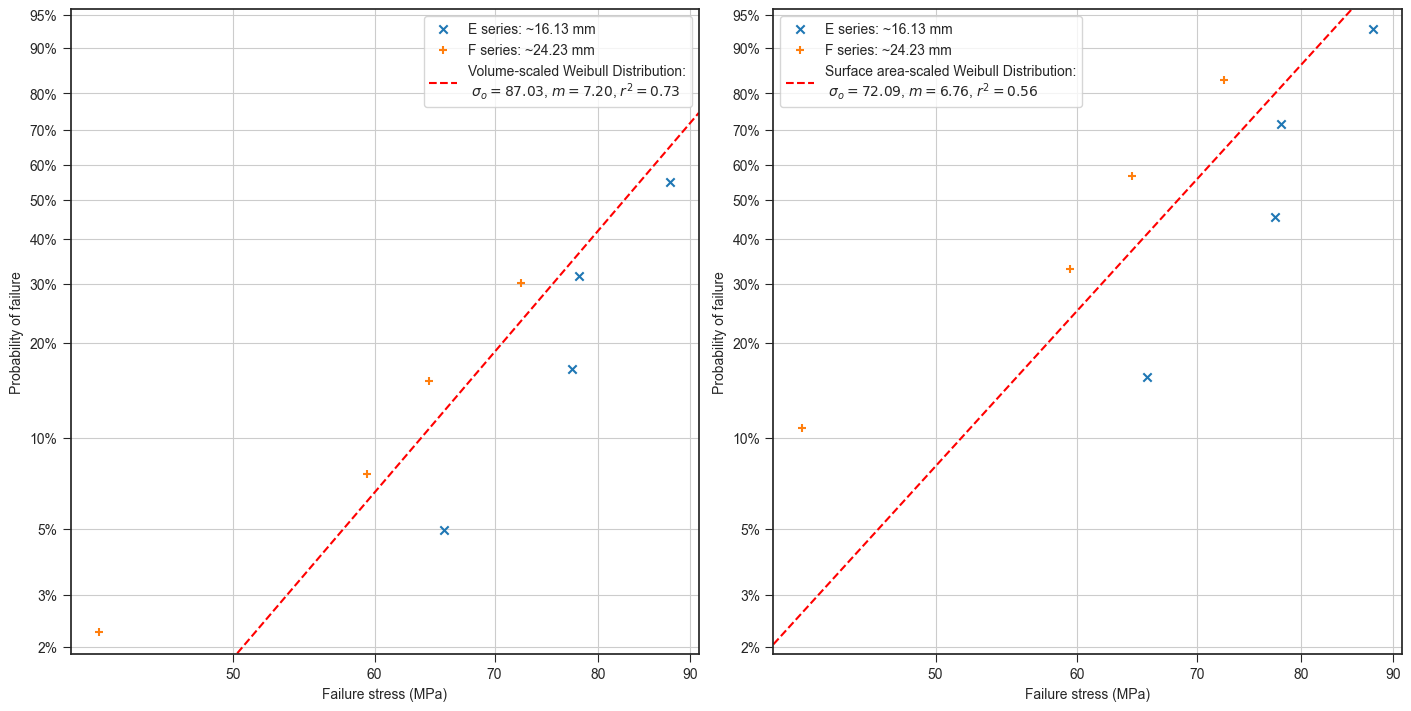

In [96]:
cast_v_dist, cast_sa_dist = plot_normalized_weibull_stage_2(cast_gcc_data_v2, cast_gcc_data_anal_v2, cast_weib_params_v, cast_weib_params_sa)

MLE scaling method: 

Scaled on volume:
Standard volume =  141.3716694115407
Weibull Scale =  87.02801656272197
Weibull Modulus =  7.204579303097992 

Scaled on surface area:
Standard surface area =  565.4866776461628
Weibull Scale =  72.09084939019621
Weibull Modulus =  6.757112000380746


(<reliability.Distributions.Weibull_Distribution at 0x1937b940b00>,
 <reliability.Distributions.Weibull_Distribution at 0x1937b940e90>)

<Figure size 640x480 with 0 Axes>

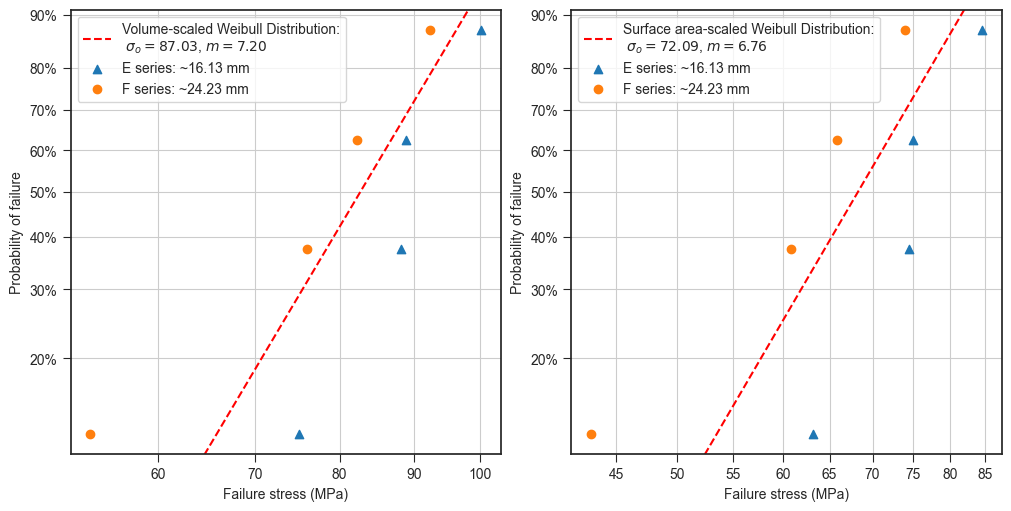

In [97]:
plot_strength_normalized_weibull(cast_gcc_data_v2, cast_gcc_data_anal_v2, cast_weib_params_v, cast_weib_params_sa)

### Plotting relation from pooled data

In [98]:
current_v_dist = vitri_v_dist
current_sa_dist = vitri_sa_dist

current_data = vitri_gcc_data_v2
current_data_anal = vitri_gcc_data_anal_v2

## Generate a range of specimen geometry
diameter_vals = np.linspace(1,8, 100)
support_span = 185
load_span = 70

## Grab a design strength from the distribution created with pooled data
v_0_05_strength = current_v_dist.quantile(0.05)
v_0_95_strength = current_v_dist.quantile(0.95)
v_char_strength = current_v_dist.alpha

sa_0_05_strength = current_sa_dist.quantile(0.05)
sa_0_95_strength = current_sa_dist.quantile(0.95)
sa_char_strength = current_sa_dist.alpha

print("1% volume Design strength is: ", v_design_strength)
print("1% surface area Design strength is: ", sa_design_strength)

1% volume Design strength is:  53.92125172474091
1% surface area Design strength is:  28.332219589480534


In [99]:
## Scale the 1% design strength and characterisitic strength according to effective volume and surface area
standard_v = current_data["standard_gage_v"].iloc[0]
standard_sa = current_data["standard_gage_sa"].iloc[0]

gage_vol = cylinder_gage_V(diameter_vals, support_span)
eff_volume = effective_V(gage_vol, load_span, support_span, current_v_dist.beta)

gage_SA = cylinder_gage_SA(diameter_vals, support_span)
eff_SA = effective_SA(gage_SA, load_span, support_span, current_sa_dist.beta)

v_lower_strength = v_0_05_strength * (standard_v / eff_volume) ** (1 / current_v_dist.beta)
v_upper_strength = v_0_95_strength * (standard_v / eff_volume) ** (1 / current_v_dist.beta)

sa_lower_strength = sa_0_05_strength * (standard_sa / eff_SA) ** (1 / current_sa_dist.beta)
sa_upper_strength = sa_0_95_strength * (standard_sa / eff_SA) ** (1 / current_sa_dist.beta)

v_char_scaled_strength = v_char_strength * (standard_v / eff_volume) ** (1 / current_v_dist.beta)
sa_char_scaled_strength = sa_char_strength * (standard_sa / eff_SA) ** (1 / current_sa_dist.beta)

a =  -0.41726653469564545
b =  2.8585123764323788


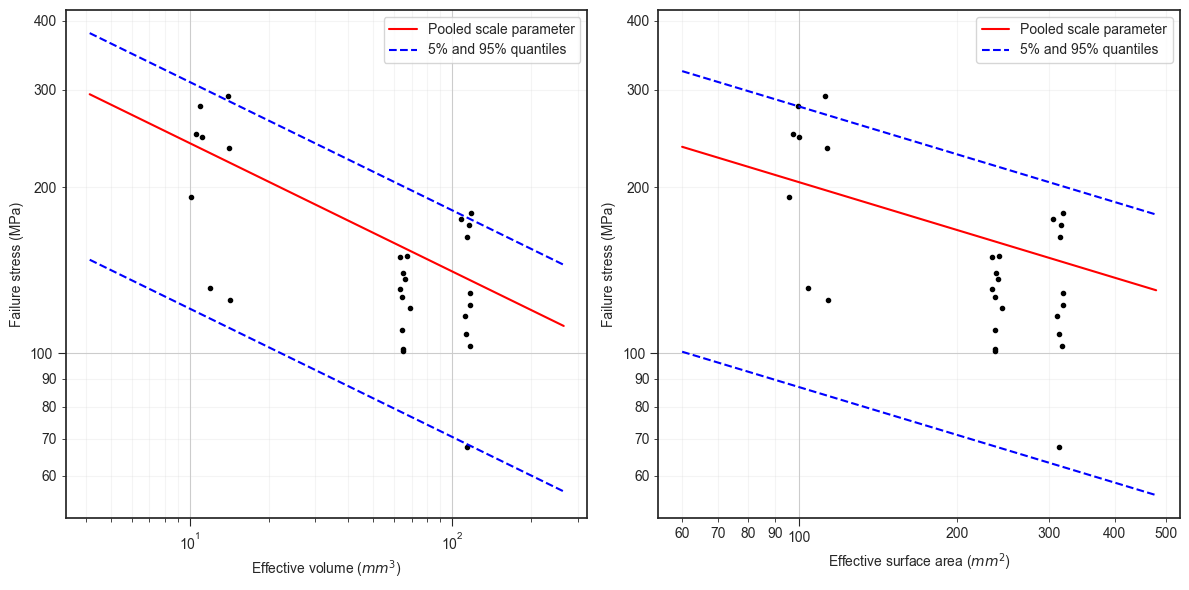

In [100]:
## Plot the range in a nice figure
fig, (ax_v, ax_sa) = plt.subplots(1,2, sharey="row")

fig.set_size_inches(12,6)

eff_vol_fit = current_data_anal["mean_effective_V"].dropna().to_numpy()
eff_SA_fit = current_data_anal["mean_effective_SA"].dropna().to_numpy()
design_strength_fit = current_data_anal["Design Strength"].dropna().to_numpy()
char_strength_fit = current_data_anal["char_strength"].dropna().to_numpy()

fit_line_fmt = "{}: \n $\\log(\\sigma_{}) = {:0.2f} \\log({}) + {:0.2f}$"

## Fitting lines of best fit to the individually determined values (black lines)
m, b = np.polyfit(np.log10(eff_vol_fit), np.log10(char_strength_fit), 1)
fit_x = np.linspace(5, 5000, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
# ax_v.plot(fit_x, fit_y, "-k", label=fit_line_fmt.format("Series scale parameter","{}", m,"V_{{eff}}",b))

m, b = np.polyfit(np.log10(eff_SA_fit), np.log10(char_strength_fit), 1)
fit_x = np.linspace(80, 2500, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
# ax_sa.plot(fit_x, fit_y, "-k", label=fit_line_fmt.format("Series scale parameter","{}", m,"A_{{eff}}",b))

m, b = np.polyfit(np.log10(eff_vol_fit), np.log10(design_strength_fit), 1)
fit_x = np.linspace(5, 5000, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
# ax_v.plot(fit_x, fit_y, "--k", label=fit_line_fmt.format("Series characteristic strength","{5\\%}",m,"V_{{eff}}",b))

m, b = np.polyfit(np.log10(eff_SA_fit), np.log10(design_strength_fit), 1)
fit_x = np.linspace(80, 2500, 100)
fit_y = np.power(10, m * np.log10(fit_x) + b)
# ax_sa.plot(fit_x, fit_y, "--k", label=fit_line_fmt.format("Series characteristic strength","{5\\%}", m,"A_{{eff}}",b))

## Individual data points on plot
# ax_v.scatter(data=current_data_anal, x="mean_effective_V", y="Design Strength", label=None, marker="x", color="k")
ax_v.scatter(data=current_data, x="effective_V", y="fracture_stress", label=None, marker=".", color="k")
# ax_sa.scatter(data=current_data_anal, x="mean_effective_SA", y="Design Strength", label=None, marker="x", color="k")
ax_sa.scatter(data=current_data, x="effective_SA", y="fracture_stress", label=None, marker=".", color="k")

## Lines on plot
ax_v.plot(eff_volume, v_char_scaled_strength, "-r", label="Pooled scale parameter")
ax_v.plot(eff_volume, v_lower_strength, "--b", label=f"5% and 95% quantiles")
ax_v.plot(eff_volume, v_upper_strength, "--b")
# ax_v.plot(eff_volume, v_scaled_strength, "--r", label="Pooled characteristic strength (5%)")
ax_v.set_xlabel("Effective volume ($mm^3$)")
ax_v.set_ylabel(stress_label)

ax_sa.plot(eff_SA, sa_char_scaled_strength, "-r", label="Pooled scale parameter")
ax_sa.plot(eff_SA, sa_lower_strength, "--b", label=f"5% and 95% quantiles")
ax_sa.plot(eff_SA, sa_upper_strength, "--b")
# ax_sa.plot(eff_SA, sa_scaled_strength, "--r", label="Pooled characteristic strength (5%)")
ax_sa.set_xlabel("Effective surface area ($mm^2$)")
ax_sa.set_ylabel(stress_label)

## Figure formatting
ax_v.set_xscale("log")
ax_v.set_yscale("log")

ax_sa.set_xscale("log")
ax_sa.set_yscale("log")

plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter()) 
plt.gca().xaxis.set_minor_formatter(mticker.ScalarFormatter())

ax_v.legend()
ax_sa.legend()

ax_v.grid(visible=True, which='major', linestyle='-')
ax_v.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

ax_sa.grid(visible=True, which='major', linestyle='-')
ax_sa.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

ax_sa.tick_params(which="both", labelleft=True)

fig.tight_layout()

print("a = ", m)
print("b = ", b)

# Stiffness Analysis

## Functions

In [101]:
def circle_inertia(dia): return (np.pi * dia ** 4) / 64

def solve_for_modulus (slope, dia, support_span, load_span):
    lever = (support_span - load_span) / 2
    inertia = circle_inertia(dia)
    return (slope / (12 * inertia)) * (3 * support_span * lever **2 - 4 * lever**3) / 1000

In [102]:
gcc_data_clean["elastic_mod"] = gcc_data_clean.apply(lambda x: solve_for_modulus(x["stiff_slope"], x["fracture_diameter"], x["support_span"], x["load_span"]), axis=1)

In [103]:
stiff_anal = gcc_data_clean[["elastic_mod", "series"]].groupby("series").agg(['mean', "std"])
stiff_anal.columns = stiff_anal.columns.map('_'.join)

stiff_anal["elastic_mod_CV"] = stiff_anal["elastic_mod_std"] / stiff_anal["elastic_mod_mean"] * 100

In [104]:
gcc_data_anal = pd.merge(gcc_data_anal, stiff_anal, on="series")

gcc_data_anal["cross_section"] = np.pi * (gcc_data_anal["fracture_diameter_mean"] ** 2)/4

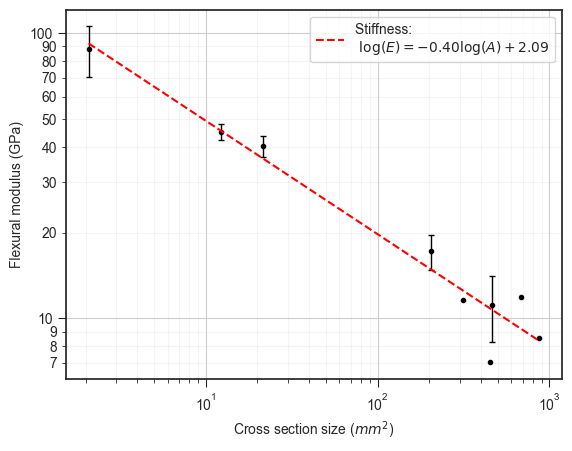

In [105]:
fig, ax = plt.subplots()

ax.scatter(data=gcc_data_anal, x="cross_section", y="elastic_mod_mean", color='k', label=None)
ax.errorbar(data=gcc_data_anal, x="cross_section", y="elastic_mod_mean", yerr="elastic_mod_std", fmt="none", elinewidth=1, ecolor="k", capsize=2.5, label=None)

cross_section = gcc_data_anal["cross_section"].dropna().to_numpy()
elastic_mod = gcc_data_anal["elastic_mod_mean"].dropna().to_numpy()

fit_line_fmt = "Stiffness: \n $\\log(E) = {:0.2f} \\log(A) + {:0.2f}$"

m, b = np.polyfit(np.log10(cross_section), np.log10(elastic_mod), 1)

fit_x = np.linspace(np.min(cross_section), np.max(cross_section), 100)

fit_y = np.power(10, m * np.log10(fit_x) + b)

ax.plot(fit_x, fit_y, "--r", label=fit_line_fmt.format(m, b))

ax.set_xlabel("Cross section size ($mm^2$)")
ax.set_ylabel("Flexural modulus (GPa)")

ax.grid(visible=True, which='major', linestyle='-')
ax.grid(visible=True, which='minor', linestyle='-', alpha=0.2)

ax.legend()
ax.set_xscale("log")
ax.set_yscale("log")

ax.yaxis.set_major_formatter(mticker.ScalarFormatter()) 
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

# Format and save final data

In [106]:
char_strength_helper = lambda row: "{:0.0f}\n({:0.0f}, {:0.0f})".format(row["char_strength"], row["char_strength_95%_lower"], row["char_strength_95%_upper"]) if row.notnull().all() else ""
gcc_data_anal["char_strength_disp"] = gcc_data_anal.apply(char_strength_helper, axis=1)

weibull_modulus_helper = lambda row: "{:.1f}\n({:.1f}, {:.1f})".format(row["weibull_modulus"], row["weibull_modulus_95%_lower"], row["weibull_modulus_95%_upper"]) if row.notnull().all() else ""
gcc_data_anal["weibull_modulus_disp"] = gcc_data_anal.apply(weibull_modulus_helper, axis=1)

In [107]:
gcc_data_anal

,fracture_diameter_mean,fracture_diameter_std,fracture_stress_mean,fracture_stress_std,...,elastic_mod_CV,cross_section,char_strength_disp,weibull_modulus_disp
series,,,,,,,,,
C,1.6275,0.115851,218.925,63.7101,...,20.078,2.08033,"243\n(196, 301)","3.5\n(1.9, 6.3)"
D,3.962,0.052451,126.708,18.0425,...,6.39768,12.3287,"134\n(123, 146)","7.8\n(4.7, 13.0)"
B,5.248,0.0725412,133.466,37.1229,...,8.35294,21.631,"148\n(124, 176)","3.7\n(2.2, 6.3)"
E,16.13,0.0559762,77.1536,9.06919,...,14.3105,204.342,"81\n(72, 92)","8.7\n(3.8, 19.8)"
G,20.04,NaN,69.2194,NaN,...,NaN,315.417,,
H,23.95,NaN,74.6243,NaN,...,NaN,450.506,,
F,24.225,0.0957427,59.5653,12.8028,...,25.9108,460.911,"65\n(51, 83)","4.4\n(1.8, 10.7)"
K,29.45,NaN,89.2743,NaN,...,NaN,681.178,,
I,33.38,NaN,66.0997,NaN,...,NaN,875.11,,


In [108]:
gcc_data_anal.to_excel("Rod_test_analysis.xlsx")

# Dog bone calcs

In [109]:
bone_stress = np.array([36,38,40,42,43])

In [110]:
bone_stress.mean()

np.float64(39.8)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Least Squares Estimation (RRX)
Failures / Right censored: 5/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         41.0949         1.36248   38.5094    43.854
     Beta         14.3896         5.44081   6.85812   30.1922 

Goodness of fit    Value
 Log-likelihood -11.9694
           AICc  33.9388
            BIC  27.1577
             AD  2.31519 



c:\Users\shawm\.virtualenvs\GlassMechAnalysis-dRiIS_5q\Lib\site-packages\reliability\Probability_plotting.py:387: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")
C:\Users\shawm\AppData\Local\Temp\ipykernel_26256\3520851353.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left")


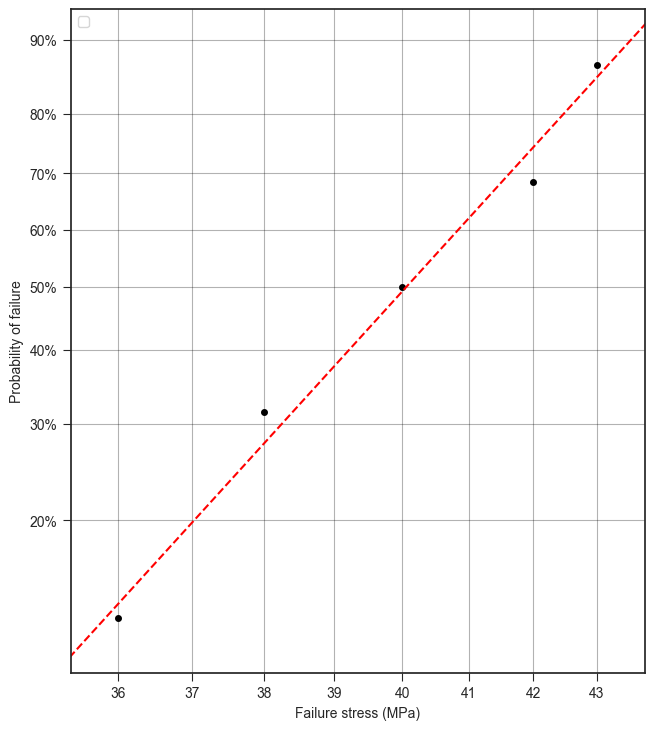

In [111]:
fig, ax = plt.subplots()

plt.sca(ax)

bone_fit = Fit_Weibull_2P(failures=bone_stress, method="LS", CI_type=None, label=None)
ax.get_lines()[0].set_color("red")
ax.get_lines()[0].set_linestyle("dashed")
fig.set_size_inches(7, 8)
plt.ylabel("Probability of failure")
plt.xlabel(stress_label)
plt.title("")
plt.legend(loc="upper left")

In [112]:
bone_fit.distribution.mean

39.63113685564401

In [113]:
bone_fit.distribution.median

np.float64(40.061435564619465)

In [114]:
bone_fit.distribution.quantile(0.05)

np.float64(33.4306340946487)

In [115]:
bone_eff_vol = ((70/130)*bone_fit.distribution.beta + 1) * (1/(2*(bone_fit.distribution.beta + 1)**2)) * (150 * 20 * 3)
bone_eff_vol

166.21789053832447

In [116]:
vitri_v_dist.alpha * (standard_v / bone_eff_vol) ** (1 / vitri_v_dist.beta)

np.float64(124.9374537709164)

In [117]:
vitri_v_dist.beta

4.3037867418281985

In [118]:
vitri_v_dist.quantile(0.05) * (standard_v / bone_eff_vol) ** (1 / vitri_v_dist.beta)

np.float64(62.65715747375645)

In [119]:
vitri_v_dist.mean * (standard_v / bone_eff_vol) ** (1 / vitri_v_dist.beta)

np.float64(113.7204007124868)

In [120]:
vitri_v_dist.median * (standard_v / bone_eff_vol) ** (1 / vitri_v_dist.beta)

np.float64(114.73816139156777)

# Ashby Plot

## Load in data

In [121]:
lit_data = pd.read_csv("Glass_Strength_Tests.csv")

In [122]:
lit_data

,paper_ID,material,test_procedure,mean_fracture_stress,...,sample_shape,sample_size,URL,Notes
0,1,soda-lime,3pt bend,105.5,...,semi-circle,5,https://doi.org/10.1016/j.engfracmech.2022.108417,Length is diameter
1,1,soda-lime,3pt bend,93.4,...,semi-circle,5,https://doi.org/10.1016/j.engfracmech.2022.108417,Length is diameter
2,1,soda-lime,3pt bend,83.8,...,semi-circle,5,https://doi.org/10.1016/j.engfracmech.2022.108417,Length is diameter
3,2,float,4pt bend,79.8,...,float rectangle,48,https://doi.org/10.1007/s40940-024-00251-6,air side
4,2,float,4pt bend,66.7,...,float rectangle,48,https://doi.org/10.1007/s40940-024-00251-6,tin side
5,2,float,4pt bend,51.3,...,float rectangle,40,https://doi.org/10.1007/s40940-024-00251-6,air side
6,2,float,4pt bend,48.5,...,float rectangle,40,https://doi.org/10.1007/s40940-024-00251-6,tin side
7,3,float,ring on ring,156.1,...,float square,20,http://resolver.tudelft.nl/uuid:0d59407b-5feb-...,air side
8,3,float,ring on ring,117.2,...,float square,20,http://resolver.tudelft.nl/uuid:0d59407b-5feb-...,tin side
9,3,float,ring on ring,134.5,...,float square,20,http://resolver.tudelft.nl/uuid:0d59407b-5feb-...,air side


## Generate mean values

In [123]:
def median_to_char(median_stress, char_stress, modulus):
    ### Convert any median weibull strengths (50%) to the characteristic strength (63%)
    if math.isnan(char_stress):
        return median_stress / ((-np.log(1-0.5))**(1/modulus))
    else:
        return char_stress

In [124]:
lit_data["weibull_fracture_stress"] = lit_data.apply(lambda row: median_to_char(row["median_fracture_stress"], row["weibull_fracture_stress"], row["weibull_modulus"]), axis=1)

In [125]:
def char_to_mean(char_stress, mean_stress, modulus):
    ### The figure needs to compare mean values, generate missing values from the reported weibull parameters
    altered = False
    if math.isnan(mean_stress):
        dist = Weibull_Distribution(alpha=char_stress, beta=modulus)
        mean_val = dist.mean
        altered = True ## Keep track if a mean value is derived, so I can report this in the table
    else:
        mean_val = mean_stress

    return pd.Series([mean_val, altered], index=["mean_fracture_stress", "altered"])

In [126]:
lit_data[["mean_fracture_stress", "altered"]] = lit_data.apply(lambda row: char_to_mean(row["weibull_fracture_stress"], row["mean_fracture_stress"], row["weibull_modulus"]), axis=1)

## Volume and Surface area

In [127]:
## What shapes do I need to calculate?
lit_data["sample_shape"].unique()

array(['semi-circle', 'float rectangle', 'float square', 'circular disk',
       'Brazilian disc', 'round bar', 'sphere', 'dog bone',
       '3d printed segment'], dtype=object)

In [128]:
def gen_sample_V(length, width, thickness, shape):
    ### Calculate sample volume for each type of shape
    if shape == 'semi-circle':
        return 0.5 * np.pi * (length/2)**2 * thickness
    elif shape == 'float rectangle' or shape == 'float square' or shape == '3d printed segment' or shape == 'dog bone':
        return length * width * thickness
    elif shape == 'circular disk':
        return np.pi * (length / 2)**2 * thickness
    elif shape == 'Brazilian disc':
        ## brazillian disk cross section = Circle - 2 * (sector - triangle)
        angle = 20
        circle_area = np.pi * (length/2)**2
        cross_section = circle_area - 2*((angle/360) * circle_area - 0.5 * (length/2)**2 * np.sin(np.deg2rad(angle)))
        return cross_section * thickness
    elif shape == 'round bar':
        return np.pi * (thickness/2)**2 * length
    elif shape == 'sphere':
        return (4/3) * np.pi * (length/2)**3
    else:
        raise ValueError("Recieved a shape without a method of calculation")
    
def gen_sample_SA(length, width, thickness, shape):
    ### Calculate sample surface area for each type of shape
    if shape == 'semi-circle':
        face_area = 0.5 * np.pi * (length/2)**2
        curve_area = 0.5 * np.pi * length * thickness
        flat_area = thickness * length
        return 2 * face_area + curve_area + flat_area
    elif shape == 'float rectangle' or shape == 'float square' or shape == '3d printed segment' or shape == 'dog bone':
        return 2 * (length * width + width * thickness + length * thickness)
    elif shape == 'circular disk':
        circle_area = np.pi * (length / 2)**2
        curve_area = np.pi * length * thickness
        return 2 * circle_area + curve_area
    elif shape == 'Brazilian disc':
        angle = 20
        circle_area = np.pi * (length/2)**2
        cross_section = circle_area - 2*((angle/360) * circle_area - 0.5 * (length/2)**2 * np.sin(np.deg2rad(angle)))
        one_curve_angle = (360 - (2 * angle)) / 2
        curve_area = (one_curve_angle/360) * np.pi * length * thickness
        base_angle = (180 - angle) / 2
        flat_area = 2 * (length/2) * np.cos(np.deg2rad(base_angle)) * thickness
        return 2 * cross_section + 2 * curve_area + 2 * flat_area
    elif shape == 'round bar':
        cross_section = np.pi * (thickness/2)**2
        round_area = np.pi * thickness * length
        return 2 * cross_section + round_area
    elif shape == 'sphere':
        return 4 * np.pi * (length/2)**2
    else:
        raise ValueError("Recieved a shape without a method of calculation")

In [129]:
v_helper = lambda row: gen_sample_V(row["length"], row["width"], row["thickness"], row["sample_shape"])
lit_data["sample_volume"] = lit_data.apply(v_helper, axis=1)

sa_helper = lambda row: gen_sample_SA(row["length"], row["width"], row["thickness"], row["sample_shape"])
lit_data["sample_surface_area"] = lit_data.apply(sa_helper, axis=1)

In [130]:
lit_data

,paper_ID,material,test_procedure,mean_fracture_stress,...,Notes,altered,sample_volume,sample_surface_area
0,1,soda-lime,3pt bend,105.5,...,Length is diameter,False,143.139,167.735
1,1,soda-lime,3pt bend,93.4,...,Length is diameter,False,322.062,299.315
2,1,soda-lime,3pt bend,83.8,...,Length is diameter,False,572.555,462.704
3,2,float,4pt bend,79.8,...,air side,False,90000,33720
4,2,float,4pt bend,66.7,...,tin side,False,90000,33720
5,2,float,4pt bend,51.3,...,air side,False,144000,41760
6,2,float,4pt bend,48.5,...,tin side,False,144000,41760
7,3,float,ring on ring,156.1,...,air side,False,625000,135000
8,3,float,ring on ring,117.2,...,tin side,False,625000,135000
9,3,float,ring on ring,134.5,...,air side,False,2.025e+06,423000


In [131]:
# lit_data = lit_data.drop(lit_data[lit_data["sample_shape"] == "sphere"].index)

## Plot

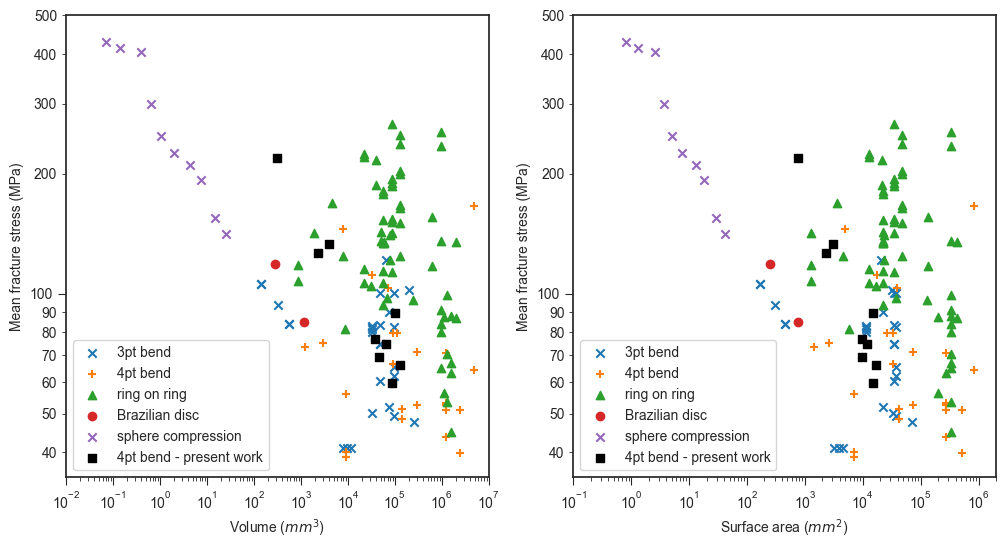

In [132]:
fig, (ax_v, ax_sa) = plt.subplots(1,2, sharey="row")
fig.set_size_inches(12,6)

test_procedure = lit_data["test_procedure"].unique()

for i, procedure in enumerate(test_procedure):
    plot_data = lit_data.loc[lit_data["test_procedure"] == procedure]

    if procedure == "4pt bend - present work":
        ax_v.scatter(data=plot_data, x="sample_volume", y="mean_fracture_stress", label=procedure, marker="s", color="k")
        ax_sa.scatter(data=plot_data, x="sample_surface_area", y="mean_fracture_stress", label=procedure, marker="s", color="k")
    else:
        marker_symb = next(marker_cycler)
        ax_v.scatter(data=plot_data, x="sample_volume", y="mean_fracture_stress", label=procedure, marker=marker_symb)
        ax_sa.scatter(data=plot_data, x="sample_surface_area", y="mean_fracture_stress", label=procedure, marker=marker_symb)


ax_v.loglog()
ax_v.set_xlabel("Volume ($mm^3$)")
ax_v.set_ylabel("Mean fracture stress (MPa)")
ax_v.set_xlim([1e-2, 1e7])
ax_v.set_ylim([None, 500])
ax_v.legend()

ax_sa.loglog()
ax_sa.set_xlabel("Surface area ($mm^2$)")
ax_sa.set_ylabel("Mean fracture stress (MPa)")
ax_sa.set_xlim([1e-1, 2e6])
ax_sa.legend()

plt.gca().yaxis.set_major_formatter(mticker.ScalarFormatter()) 
plt.gca().yaxis.set_minor_formatter(mticker.ScalarFormatter())

ax_sa.tick_params(which="both", labelleft=True)

In [133]:
def identify_altered(mean_stress, altered):
    ### Add an apostrophe to datapoints if they have been derived from weibull parameters
    if altered:
        return "*%.1f" % mean_stress
    else:
        return "%.1f" % mean_stress
    
lit_data["mean_stress_display"] = lit_data.apply(lambda row: identify_altered(row["mean_fracture_stress"], row["altered"]), axis=1)

lit_data.to_excel("collated_testing.xlsx")